In [32]:
# -*- coding: utf-8 -*-
"""AI Voice Detector with Comprehensive Model Comparison and XAI Analysis

Complete implementation with ensemble models and explainable AI features.
"""

import os
import subprocess
import sys

def setup_colab():
    """Helper function to set up Google Colab environment"""

    print("Setting up Google Colab environment...")

    # Install system-level packages
    try:
        subprocess.check_call(['apt-get', 'update'])
        subprocess.check_call(['apt-get', 'install', '-y', 'ffmpeg'])
        print("✓ Installed ffmpeg")
    except subprocess.CalledProcessError:
        print("✗ Failed to install ffmpeg")

    # Install required Python packages
    packages = [
        'librosa',
        'soundfile',
        'torchaudio',
        'seaborn',
        'tqdm',
        'demucs',
        'captum',  # For XAI
        'shap',    # For SHAP analysis
        'lime',    # For LIME explanations
        'plotly',  # For interactive plots
        'scikit-plot',  # For enhanced metrics
        'opencv-python',
        'librosa',
        'matplotlib',
        'pandas',
        'numpy',
        'scikit-learn',
        'torch',
        'torchvision',
        'Pillow'
    ]

    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✓ Installed {package}")
        except subprocess.CalledProcessError:
            print(f"✗ Failed to install {package}")

    # Create directory structure
    os.makedirs('./dataset/ai', exist_ok=True)
    os.makedirs('./dataset/real', exist_ok=True)
    os.makedirs('./output', exist_ok=True)
    os.makedirs('./xai_results', exist_ok=True)

    print("✓ Created directory structure")
    print("✓ Colab setup complete!")
    print("\nNext steps:")
    print("1. Upload your AI audio files to ./dataset/ai/")
    print("2. Upload your Real audio files to ./dataset/real/")
    print("3. Run main() to start the application")

# Only run setup in Colab environment
try:
    import google.colab
    # setup_colab()
except ImportError:
    print("Running in local environment - skipping Colab setup")

print("Current working directory:", os.getcwd())

"""
AI vs Real Voice Detection System with XAI Analysis
Enhanced with comprehensive model comparison and explainable AI
"""

import os
import random
import glob
import hashlib
import warnings
import logging
import sys
from datetime import datetime
from typing import List, Dict, Tuple, Optional, Any

import time
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image, ImageFile
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score, accuracy_score
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import soundfile as sf
import torchvision.transforms as T
from torchvision.models import (
    resnet18, efficientnet_b0, efficientnet_b1,
    densenet121, densenet169, mobilenet_v3_small,
    convnext_tiny, vit_b_16, swin_t
)

# XAI imports
try:
    from captum.attr import IntegratedGradients, Saliency, Occlusion, LayerGradCam
    from captum.attr import visualization as viz
    import shap
    from lime import lime_image
    CAPTUM_AVAILABLE = True
except ImportError:
    CAPTUM_AVAILABLE = False
    print("XAI libraries not fully available")

try:
    import scikitplot as skplt
    SKPLOT_AVAILABLE = True
except ImportError:
    SKPLOT_AVAILABLE = False

# Critical stability settings
ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.filterwarnings('ignore')
os.environ['TORCHAUDIO_USE_BACKEND_DISPATCHER'] = '0'

# ============================================================================
# LOGGING SETUP
# ============================================================================
class LoggerSetup:
    """Configure logging for the entire application"""

    @staticmethod
    def setup_logger(
        log_file: str = "ai_voice_detection_log.txt",
        level=logging.INFO,
        console: bool = True
    ):
        """Setup logger with file handler, optionally console output"""
        logger = logging.getLogger('AIVoiceDetection')
        logger.setLevel(level)
        logger.handlers.clear()

        # Formatter for file
        detailed_formatter = logging.Formatter(
            '%(asctime)s - %(name)s - %(levelname)s - %(funcName)s:%(lineno)d - %(message)s',
            datefmt='%Y-%m-%d %H:%M:%S'
        )

        # File handler
        file_handler = logging.FileHandler(log_file, mode='a', encoding='utf-8')
        file_handler.setLevel(logging.DEBUG)
        file_handler.setFormatter(detailed_formatter)
        logger.addHandler(file_handler)

        # Optional console handler
        if console:
            simple_formatter = logging.Formatter(
                '%(asctime)s - %(levelname)s - %(message)s',
                datefmt='%H:%M:%S'
            )
            console_handler = logging.StreamHandler(sys.stdout)
            console_handler.setLevel(logging.INFO)
            console_handler.setFormatter(simple_formatter)
            logger.addHandler(console_handler)

        # Log initial setup
        logger.info("="*80)
        logger.info(f"Logging initialized - Session started at {datetime.now()}")
        logger.info("="*80)

        return logger

# Initialize logger
logger = LoggerSetup.setup_logger(console=True)

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Central configuration for the entire pipeline"""

    # Paths
    COMBINED_DIR = r"./dataset"
    AI_DIR = os.path.join(COMBINED_DIR, "ai")
    REAL_DIR = os.path.join(COMBINED_DIR, "real")
    CLEAN_DIR = os.path.join("./output", "clean_audio_unique")
    IMG_DIR = os.path.join("./output", "spectrogram_images_clean_unique")
    SPLIT_DIR = os.path.join("./output", "_splits")
    XAI_DIR = os.path.join("./xai_results")

    # Audio settings
    SR = 16000
    N_FFT = 1024
    HOP = 160
    N_MELS = 128
    F_MIN = 20.0
    F_MAX = SR / 2 - 20.0

    # Denoising settings
    DENOISE_WIN = 1024
    DENOISE_HOP = 256
    DENOISE_NOISE_FRAMES = 20
    DENOISE_THRESH_DB = 6.0
    DENOISE_ATTEN_DB = 20.0

    # VAD settings
    VAD_FRAME_MS = 20
    VAD_THR_RATIO = 0.5
    VAD_PAD_MS = 100

    # Preprocessing
    PRE_EMPH = 0.97
    HPF_CUTOFF = 40.0
    MIN_SAMPLES = HOP * 6

    # Training settings
    IMG_SIZE = 224
    BATCH_SIZE = 32
    NUM_WORKERS = 2
    EPOCHS = 1
    LR = 3e-4
    WEIGHT_DECAY = 1e-4
    PATIENCE = 5

    # System
    SEED = 42
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    # Audio extensions
    AUDIO_EXTS = (".wav", ".mp3", ".flac", ".m4a", ".ogg", ".aac", ".wma",
                  ".WAV", ".MP3", ".FLAC", ".M4A", ".OGG", ".AAC", ".WMA")

    # Models to compare
    MODELS_TO_COMPARE = [
        "resnet18",
        "efficientnet_b0",
        "densenet121",
        "mobilenet_v3_small",
        "convnext_tiny",
        "vit_b16",
        "swin_tiny"
    ]

    # Ensemble configurations
    ENSEMBLE_CONFIGS = {
        "hybrid_ensemble": ["resnet18", "efficientnet_b0", "convnext_tiny"],
        "light_ensemble": ["efficientnet_b0", "mobilenet_v3_small"],
        "heavy_ensemble": ["resnet18", "densenet121", "convnext_tiny", "swin_tiny"]
    }

    @classmethod
    def setup_environment(cls):
        """Initialize environment settings"""
        logger.info("Setting up environment...")

        random.seed(cls.SEED)
        np.random.seed(cls.SEED)
        torch.manual_seed(cls.SEED)
        if cls.DEVICE == "cuda":
            torch.cuda.manual_seed(cls.SEED)

        logger.info(f"Random seed set to: {cls.SEED}")
        logger.info(f"Device: {cls.DEVICE}")

        if cls.DEVICE == "cuda":
            torch.backends.cudnn.benchmark = True
            logger.info(f"CUDA available - GPU: {torch.cuda.get_device_name(0)}")
            logger.info(f"CUDA version: {torch.version.cuda}")

        # Create directories
        for d in [cls.CLEAN_DIR, cls.IMG_DIR, cls.SPLIT_DIR, cls.XAI_DIR]:
            os.makedirs(d, exist_ok=True)
            logger.debug(f"Directory ensured: {d}")

        logger.info("Environment setup complete")


Current working directory: /content
09:24:33 - INFO - ================================================================================


INFO:AIVoiceDetection:================================================================================


09:24:33 - INFO - Logging initialized - Session started at 2025-11-11 09:24:33.388456


INFO:AIVoiceDetection:Logging initialized - Session started at 2025-11-11 09:24:33.388456


09:24:33 - INFO - ================================================================================


INFO:AIVoiceDetection:================================================================================


In [33]:

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

class FileUtils:
    """File and path utilities"""

    @staticmethod
    def list_audio_files(folder: str, exts: tuple = Config.AUDIO_EXTS) -> List[str]:
        """Recursively list all audio files in folder"""
        logger.debug(f"Scanning for audio files in: {folder}")
        files = []

        for ext in exts:
            found = glob.glob(os.path.join(folder, f"**/*{ext}"), recursive=True)
            files.extend(found)
            if found:
                logger.debug(f"Found {len(found)} files with extension {ext}")

        logger.info(f"Total audio files found in {folder}: {len(files)}")
        return files

    @staticmethod
    def list_image_files(folder: str, exts: tuple = (".png", ".jpg", ".jpeg")) -> List[str]:
        """Recursively list all image files in a folder"""
        logger.debug(f"Scanning for image files in: {folder}")
        files = []
        for ext in exts:
            found = glob.glob(os.path.join(folder, f"**/*{ext}"), recursive=True)
            files.extend(found)

        logger.info(f"Total image files found in {folder}: {len(files)}")
        return files

    @staticmethod
    def unique_output_name(src_path: str) -> str:
        """Generate unique output name: <basename>__<ext>__<hash>.wav"""
        base, ext = os.path.splitext(os.path.basename(src_path))
        # Include timestamp (milliseconds)
        unique_str = f"{os.path.abspath(src_path)}_{time.time_ns()}"
        h = hashlib.sha1(unique_str.encode("utf-8")).hexdigest()[:10]
        name = f"{base}__{ext.lstrip('.').lower()}__{h}.wav"
        logger.debug(f"Generated unique name: {name}")
        return name

# ============================================================================
# AUDIO PROCESSING
# ============================================================================

class AudioLoader:
    """Load any audio file robustly using multiple fallback methods"""

    def __init__(self, target_sr: int = 16000, device: str = "cuda"):
        self.target_sr = target_sr
        self.device = device
        logger.debug(f"AudioLoader initialized - SR: {target_sr}, Device: {device}")

    @torch.no_grad()
    def load(self, path: str) -> torch.Tensor:
        logger.debug(f"Loading audio: {path}")

        # Try torchaudio first
        try:
            wav, sr = torchaudio.load(path)
            if wav.shape[0] > 1:
                wav = wav.mean(dim=0, keepdim=True)
                logger.debug("Converted stereo to mono")
            if sr != self.target_sr:
                wav = torchaudio.functional.resample(wav, sr, self.target_sr)
                logger.debug(f"Resampled from {sr}Hz to {self.target_sr}Hz")
            mx = torch.amax(torch.abs(wav))
            if mx > 0: wav = wav / mx
            logger.debug(f"Successfully loaded with torchaudio - shape: {wav.shape}")
            return wav.to(self.device)
        except Exception as e:
            logger.debug(f"Torchaudio failed: {str(e)}")

        # Try soundfile
        try:
            y, sr = sf.read(path, dtype="float32", always_2d=False)
            if y.ndim == 2: y = y.mean(axis=1)
            wav = torch.from_numpy(y).unsqueeze(0)
            if sr != self.target_sr:
                wav = torchaudio.functional.resample(wav, sr, self.target_sr)
            mx = torch.amax(torch.abs(wav))
            if mx > 0: wav = wav / mx
            logger.debug(f"Successfully loaded with soundfile - shape: {wav.shape}")
            return wav.to(self.device)
        except Exception as e:
            logger.debug(f"Soundfile failed: {str(e)}")

        # Try librosa
        try:
            y, sr = librosa.load(path, sr=self.target_sr, mono=True)
            wav = torch.from_numpy(y.astype(np.float32)).unsqueeze(0).to(self.device)
            mx = torch.amax(torch.abs(wav))
            if mx > 0: wav = wav / mx
            logger.debug(f"Successfully loaded with librosa - shape: {wav.shape}")
            return wav
        except Exception as e:
            logger.error(f"All loading methods failed for {path}: {str(e)}")
            return None

    @staticmethod
    def _normalize(wav):
        mx = torch.amax(torch.abs(wav))
        return wav / (mx + 1e-8)


class AudioDenoiser:
    """Audio denoising with spectral gating and optional Demucs"""

    def __init__(self, device: str = Config.DEVICE):
        self.device = device
        self.window = torch.hann_window(Config.DENOISE_WIN, device=device)
        self.demucs_model = None
        self.demucs_apply_model = None
        self.demucs_ok = False
        self._init_demucs()
        logger.debug(f"AudioDenoiser initialized - Demucs available: {self.demucs_ok}")

    def _init_demucs(self):
        """Initialize Demucs model if available"""
        # First try to import apply_model
        try:
            from demucs.apply import apply_model
            self.demucs_apply_model = apply_model
        except ImportError:
            self.demucs_apply_model = None
            logger.debug("apply_model not available")

        # Then try to load the model
        try:
            from demucs.pretrained import get_model as demucs_get_model
            self.demucs_model = demucs_get_model("htdemucs")
            self.demucs_model.to(self.device).eval()
            self.demucs_ok = True
            logger.info("Demucs model loaded successfully (from pretrained)")
        except Exception as e:
            logger.debug(f"Demucs pretrained loading failed: {e}")
            try:
                self.demucs_model = torch.hub.load("facebookresearch/demucs:main", "htdemucs")
                self.demucs_model.to(self.device).eval()
                self.demucs_ok = True
                logger.info("Demucs model loaded successfully (from torch.hub)")
            except Exception as e2:
                logger.warning(f"Demucs not available: {e2}")
                self.demucs_ok = False

    @torch.no_grad()
    def denoise(self, wav: torch.Tensor, method: str = "auto") -> torch.Tensor:
        """Denoise audio"""
        logger.debug(f"Denoising with method: {method}")

        if method == "demucs":
            result = self._demucs_denoise(wav)
            if result is None:
                logger.error("Demucs denoising failed")
                raise RuntimeError("Demucs failed")
            return result
        elif method == "spectral":
            return self._spectral_gate(wav)
        else:  # auto
            result = self._demucs_denoise(wav)
            if result is not None:
                logger.debug("Used Demucs denoising")
                return result
            logger.debug("Falling back to spectral gating")
            return self._spectral_gate(wav)

    @torch.no_grad()
    def _spectral_gate(self, wav: torch.Tensor) -> torch.Tensor:
        """Spectral gating denoising"""
        logger.debug("Applying spectral gating")

        stft = torch.stft(
            wav, n_fft=Config.DENOISE_WIN, hop_length=Config.DENOISE_HOP,
            win_length=Config.DENOISE_WIN, window=self.window,
            center=True, return_complex=True
        )

        mag = torch.abs(stft) + 1e-8
        phase = stft / mag

        # Estimate noise
        N = min(Config.DENOISE_NOISE_FRAMES, mag.shape[-1])
        noise = mag[..., :N].median(dim=-1, keepdim=True).values

        # Apply gate
        mag_db = 20.0 * torch.log10(mag)
        noise_db = 20.0 * torch.log10(noise + 1e-8)
        keep = (mag_db - noise_db) >= Config.DENOISE_THRESH_DB
        atten = 10 ** (-Config.DENOISE_ATTEN_DB / 20.0)
        mag_dn = torch.where(keep, mag, mag * atten)

        # Reconstruct
        stft_dn = mag_dn * phase
        wav_out = torch.istft(
            stft_dn, n_fft=Config.DENOISE_WIN, hop_length=Config.DENOISE_HOP,
            win_length=Config.DENOISE_WIN, window=self.window,
            center=True, length=wav.shape[-1]
        ).unsqueeze(0)

        logger.debug("Spectral gating complete")
        return AudioLoader._normalize(wav_out)

    @torch.no_grad()
    def _demucs_denoise(self, wav: torch.Tensor) -> Optional[torch.Tensor]:
        """
        Use Demucs to separate 'vocals' from 'other' and keep vocals as denoised speech.
        If Demucs fails, returns None.
        """
        if not self.demucs_ok or self.demucs_model is None:
            return None

        # Ensure input is on correct device and is a tensor
        if not isinstance(wav, torch.Tensor):
            logger.error(f"Expected torch.Tensor, got {type(wav)}")
            return None

        if wav.device != self.device:
            wav = wav.to(self.device)

        try:
            logger.debug(f"Running Demucs vocal separation on tensor shape: {wav.shape}")

            # Store original shape for restoration
            original_shape = wav.shape

            # Convert mono to stereo for Demucs (which expects 2 channels)
            if len(original_shape) == 1:
                # Mono: (T,) -> (2, T) by duplicating
                wav_stereo = wav.unsqueeze(0).repeat(2, 1)
            elif len(original_shape) == 2 and original_shape[0] == 1:
                # Mono: (1, T) -> (2, T) by duplicating
                wav_stereo = wav.repeat(2, 1)
            else:
                # Already stereo or multi-channel, use as is
                wav_stereo = wav

            # Prepare input: (batch, channels, samples)
            x = wav_stereo.unsqueeze(0)  # (1, channels, T)

            # Use apply_model if available, otherwise use direct model call
            if self.demucs_apply_model is not None:
                logger.debug("Using apply_model for Demucs")
                out = self.demucs_apply_model(self.demucs_model, x, device=self.device)
            else:
                logger.debug("Using direct model call for Demucs")
                out = self.demucs_model(x)

            # Handle output - extract vocals
            if isinstance(out, (list, tuple)):
                out = out[0]

            if out.dim() == 4:
                # Standard case: (batch, sources, channels, samples)
                # Get vocals index - typically 3 for htdemucs
                vocals_idx = getattr(self.demucs_model, "sources", ['drums','bass','other','vocals']).index('vocals') \
                            if hasattr(self.demucs_model, "sources") and 'vocals' in self.demucs_model.sources else 3
                vocals = out[:, vocals_idx, :, :]  # Get vocals source (1, channels, T)

                # Convert back to original channel format
                if len(original_shape) == 1 or (len(original_shape) == 2 and original_shape[0] == 1):
                    # Original was mono - average stereo channels
                    vocals = vocals.mean(dim=1, keepdim=True)  # (1, 1, T)
                else:
                    # Keep stereo
                    vocals = vocals  # (1, channels, T)

                # Remove batch dimension
                vocals = vocals.squeeze(0)  # (channels, T)

            elif out.dim() == 3:
                # Alternative output format
                vocals = out[-1, :, :]  # Take last source as vocals
                if len(original_shape) == 1 or (len(original_shape) == 2 and original_shape[0] == 1):
                    vocals = vocals.mean(dim=0, keepdim=True)  # Convert to mono if original was mono
            else:
                logger.warning(f"Unexpected Demucs output shape: {out.shape}")
                return None

            # Ensure we have a valid tensor
            if not isinstance(vocals, torch.Tensor):
                logger.error(f"Demucs returned non-tensor: {type(vocals)}")
                return None

            # Normalize
            wav_clean = vocals
            mx = torch.amax(torch.abs(wav_clean))
            if mx > 0:
                wav_clean = wav_clean / mx

            logger.debug(f"Demucs separation successful, output shape: {wav_clean.shape}")
            return wav_clean

        except Exception as e:
            logger.warning(f"Demucs processing failed: {e}")
            return None

class AudioPreprocessor:
    """Audio preprocessing: VAD, HPF, pre-emphasis"""

    def __init__(self, sr: int = Config.SR, device: str = Config.DEVICE):
        self.sr = sr
        self.device = device
        logger.debug(f"AudioPreprocessor initialized - SR: {sr}")

    @torch.no_grad()
    def process(self, wav: torch.Tensor) -> Optional[torch.Tensor]:
        """Full preprocessing pipeline"""
        logger.debug("Starting audio preprocessing")

        # VAD trimming
        wav = self._vad_trim(wav)
        logger.debug(f"After VAD trim: {wav.shape}")

        # High-pass filter
        if Config.HPF_CUTOFF > 0:
            wav = torchaudio.functional.highpass_biquad(wav, self.sr, Config.HPF_CUTOFF)
            logger.debug("Applied high-pass filter")

        # Pre-emphasis
        if Config.PRE_EMPH > 0:
            wav = self._pre_emphasize(wav)
            logger.debug("Applied pre-emphasis")

        # Normalize
        wav = AudioLoader._normalize(wav)

        # Check length
        if wav.shape[-1] < Config.MIN_SAMPLES:
            logger.warning(f"Audio too short after preprocessing: {wav.shape[-1]} < {Config.MIN_SAMPLES}")
            return None

        logger.debug("Preprocessing complete")
        return wav

    @torch.no_grad()
    def _vad_trim(self, wav: torch.Tensor) -> torch.Tensor:
        """Simple VAD-based trimming"""
        T = wav.shape[-1]
        hop = int(self.sr * Config.VAD_FRAME_MS / 1000.0)
        win = hop

        if T < win:
            return wav

        frames = wav.unfold(dimension=-1, size=win, step=hop)
        energy = (frames ** 2).mean(dim=-1).squeeze(0)
        thr = torch.median(energy) * Config.VAD_THR_RATIO
        mask = energy > thr

        if not mask.any():
            return wav

        idx = torch.nonzero(mask, as_tuple=False).squeeze(1)
        start_f, end_f = idx[0].item(), idx[-1].item()
        pad = int(self.sr * Config.VAD_PAD_MS / 1000.0)
        start = max(0, start_f * hop - pad)
        end = min(T, (end_f + 1) * hop + pad)

        return wav[:, start:end] if end > start else wav

    @staticmethod
    def _pre_emphasize(wav: torch.Tensor) -> torch.Tensor:
        """Apply pre-emphasis filter"""
        x_shift = torch.zeros_like(wav)
        x_shift[..., 1:] = wav[..., :-1]
        return wav - Config.PRE_EMPH * x_shift


class SpectrogramGenerator:
    """Generate mel spectrograms from audio"""

    def __init__(self, device: str = Config.DEVICE):
        self.device = device
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=Config.SR, n_fft=Config.N_FFT, hop_length=Config.HOP,
            n_mels=Config.N_MELS, f_min=Config.F_MIN, f_max=Config.F_MAX,
            power=2.0
        ).to(device)
        self.amp2db = torchaudio.transforms.AmplitudeToDB(
            stype="power", top_db=80
        ).to(device)
        logger.debug("SpectrogramGenerator initialized")

    @torch.no_grad()
    def generate(self, wav: torch.Tensor) -> np.ndarray:
        """Generate mel spectrogram image (uint8 numpy array)"""
        logger.debug("Generating spectrogram")
        S = self.mel_transform(wav)
        S_db = self.amp2db(S).squeeze(0)

        # Normalize to [0, 255]
        a = (S_db - S_db.amin()) / (S_db.amax() - S_db.amin() + 1e-8)
        a = (a * 255.0).clamp(0, 255).to(torch.uint8)

        return a.detach().cpu().numpy()

    @torch.no_grad()
    def wav_to_tensor(self, wav: torch.Tensor, img_size: int = Config.IMG_SIZE) -> torch.Tensor:
        """Generate normalized tensor for model input (1, 1, H, W)"""
        img_array = self.generate(wav)
        pil_img = Image.fromarray(img_array).resize(
            (img_size, img_size), Image.BILINEAR
        )
        x = torch.from_numpy(np.array(pil_img)).float()
        x = x.unsqueeze(0).unsqueeze(0) / 255.0  # (1, 1, H, W)
        x = (x - 0.5) / 0.5  # Normalize like training
        return x.to(self.device)

# ============================================================================
# DATASET AND DATA PROCESSING
# ============================================================================

class SpectrogramDataset(Dataset):
    """Dataset for spectrogram images"""

    def __init__(self, csv_path: str, augment: bool = False,
                 img_size: int = Config.IMG_SIZE):
        df = pd.read_csv(csv_path)
        self.paths = df["path"].tolist()
        self.labels = df["label"].astype(int).tolist()
        self.img_size = img_size

        logger.info(f"Dataset loaded from {csv_path}: {len(self.paths)} samples")

        if augment:
            self.transform = T.Compose([
                T.Resize((img_size, img_size)),
                T.RandomApply([
                    T.RandomAffine(degrees=5, translate=(0.02, 0.02),
                                  scale=(0.98, 1.02))
                ], p=0.5),
                T.ToTensor(),
                T.Normalize(mean=[0.5], std=[0.5]),
            ])
            logger.debug("Using augmented transforms")
        else:
            self.transform = T.Compose([
                T.Resize((img_size, img_size)),
                T.ToTensor(),
                T.Normalize(mean=[0.5], std=[0.5]),
            ])
            logger.debug("Using standard transforms")

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        try:
            img = Image.open(self.paths[idx]).convert("L")
            x = self.transform(img)
        except Exception as e:
            logger.error(f"Failed to load image {self.paths[idx]}: {e}")
            # Fallback: return zeros
            x = torch.zeros(1, self.img_size, self.img_size, dtype=torch.float32)

        return x, self.labels[idx]


class DatasetBuilder:
    """Build and manage datasets"""

    def __init__(self, base_dir: str = Config.IMG_DIR):
        self.base_dir = base_dir
        self.split_dir = os.path.join(base_dir, "_splits")
        os.makedirs(self.split_dir, exist_ok=True)
        logger.info(f"DatasetBuilder initialized - base: {base_dir}")

    def create_splits(self, test_size: float = 0.2, val_size: float = 0.5):
        """Create train/val/test splits"""
        logger.info("Creating dataset splits...")

        ai_files = FileUtils.list_image_files(os.path.join(self.base_dir, "ai"))
        real_files = FileUtils.list_image_files(os.path.join(self.base_dir, "real"))

        logger.info(f"AI images: {len(ai_files)}, Real images: {len(real_files)}")

        paths = ai_files + real_files
        labels = [1] * len(ai_files) + [0] * len(real_files)

        # Stratified split
        train_paths, temp_paths, train_labels, temp_labels = train_test_split(
            paths, labels, test_size=test_size, random_state=Config.SEED,
            stratify=labels
        )
        val_paths, test_paths, val_labels, test_labels = train_test_split(
            temp_paths, temp_labels, test_size=val_size,
            random_state=Config.SEED, stratify=temp_labels
        )

        logger.info(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

        # Save CSVs
        self._save_split("train", train_paths, train_labels)
        self._save_split("val", val_paths, val_labels)
        self._save_split("test", test_paths, test_labels)

        logger.info("Dataset splits created successfully")

    def _save_split(self, name: str, paths: List[str], labels: List[int]):
        """Save split to CSV"""
        df = pd.DataFrame({"path": paths, "label": labels})
        csv_path = os.path.join(self.split_dir, f"{name}.csv")
        df.to_csv(csv_path, index=False)
        logger.debug(f"Saved {name} split to {csv_path}")

    def get_dataloaders(self, batch_size: int = Config.BATCH_SIZE,
                       num_workers: int = Config.NUM_WORKERS) -> Dict[str, DataLoader]:
        """Get train/val/test dataloaders"""
        logger.info("Creating dataloaders...")

        train_ds = SpectrogramDataset(
            os.path.join(self.split_dir, "train.csv"), augment=True
        )
        val_ds = SpectrogramDataset(
            os.path.join(self.split_dir, "val.csv"), augment=False
        )
        test_ds = SpectrogramDataset(
            os.path.join(self.split_dir, "test.csv"), augment=False
        )

        pin_memory = Config.DEVICE == "cuda"

        loaders = {
            "train": DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory),
            "val": DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=pin_memory),
            "test": DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=pin_memory),
        }

        logger.info(f"Dataloaders created - batch_size: {batch_size}")
        return loaders

# ============================================================================
# MODELS
# ============================================================================

class ModelFactory:
    """Factory for creating different model architectures"""

    @staticmethod
    def create_model(name: str) -> nn.Module:
        """Create model by name"""
        logger.info(f"Creating model: {name}")
        name = name.lower()

        model_map = {
            "resnet18": ModelFactory._create_resnet18,
            "efficientnet_b0": ModelFactory._create_efficientnet_b0,
            "efficientnet_b1": ModelFactory._create_efficientnet_b1,
            "densenet121": ModelFactory._create_densenet121,
            "densenet169": ModelFactory._create_densenet169,
            "mobilenet_v3_small": ModelFactory._create_mobilenet_v3_small,
            "convnext_tiny": ModelFactory._create_convnext_tiny,
            "vit_b16": ModelFactory._create_vit_b16,
            "swin_tiny": ModelFactory._create_swin_tiny,
        }

        if name not in model_map:
            logger.error(f"Unknown model: {name}")
            raise ValueError(f"Unknown model: {name}")

        model = model_map[name]()
        logger.info(f"Model {name} created successfully")
        return model

    @staticmethod
    def _create_resnet18() -> nn.Module:
        model = resnet18(weights=None)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Linear(model.fc.in_features, 2)
        return model

    @staticmethod
    def _create_efficientnet_b0() -> nn.Module:
        model = efficientnet_b0(weights=None)
        first = model.features[0][0]
        model.features[0][0] = nn.Conv2d(
            1, first.out_channels, kernel_size=first.kernel_size,
            stride=first.stride, padding=first.padding, bias=(first.bias is not None)
        )
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
        return model

    @staticmethod
    def _create_efficientnet_b1() -> nn.Module:
        model = efficientnet_b1(weights=None)
        first = model.features[0][0]
        model.features[0][0] = nn.Conv2d(
            1, first.out_channels, kernel_size=first.kernel_size,
            stride=first.stride, padding=first.padding, bias=(first.bias is not None)
        )
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
        return model

    @staticmethod
    def _create_densenet121() -> nn.Module:
        model = densenet121(weights=None)
        first = model.features.conv0
        model.features.conv0 = nn.Conv2d(
            1, first.out_channels, kernel_size=first.kernel_size,
            stride=first.stride, padding=first.padding, bias=(first.bias is not None)
        )
        model.classifier = nn.Linear(model.classifier.in_features, 2)
        return model

    @staticmethod
    def _create_densenet169() -> nn.Module:
        model = densenet169(weights=None)
        first = model.features.conv0
        model.features.conv0 = nn.Conv2d(
            1, first.out_channels, kernel_size=first.kernel_size,
            stride=first.stride, padding=first.padding, bias=(first.bias is not None)
        )
        model.classifier = nn.Linear(model.classifier.in_features, 2)
        return model

    @staticmethod
    def _create_mobilenet_v3_small() -> nn.Module:
        model = mobilenet_v3_small(weights=None)
        first = model.features[0][0]
        model.features[0][0] = nn.Conv2d(
            1, first.out_channels, kernel_size=first.kernel_size,
            stride=first.stride, padding=first.padding, bias=(first.bias is not None)
        )
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
        return model

    @staticmethod
    def _create_convnext_tiny() -> nn.Module:
        model = convnext_tiny(weights=None)
        model.features[0][0] = nn.Conv2d(1, 96, kernel_size=4, stride=4, padding=0, bias=True)
        model.classifier[2] = nn.Linear(model.classifier[2].in_features, 2)
        return model

    @staticmethod
    def _create_vit_b16() -> nn.Module:
        model = vit_b_16(weights=None)
        embed_dim = model.conv_proj.out_channels
        model.conv_proj = nn.Conv2d(1, embed_dim, kernel_size=16, stride=16, bias=True)

        try:
            in_features = model.heads.head.in_features
            model.heads.head = nn.Linear(in_features, 2)
        except Exception:
            last = list(model.heads.children())[-1]
            in_features = last.in_features
            model.heads = nn.Sequential(nn.Linear(in_features, 2))

        return model

    @staticmethod
    def _create_swin_tiny() -> nn.Module:
        model = swin_t(weights=None)
        old = model.features[0][0]
        model.features[0][0] = nn.Conv2d(
            1, old.out_channels, kernel_size=old.kernel_size,
            stride=old.stride, padding=old.padding, bias=(old.bias is not None)
        )
        model.head = nn.Linear(model.head.in_features, 2)
        return model

# ============================================================================
# ENSEMBLE MODELS
# ============================================================================

class EnhancedEnsembleModel(nn.Module):
    """Enhanced ensemble model with XAI support"""

    def __init__(self, models: List[nn.Module], model_names: List[str] = None):
        super().__init__()
        self.models = nn.ModuleList(models)
        self.model_names = model_names or [f"model_{i}" for i in range(len(models))]
        self.fc = nn.Linear(len(models) * 2, 2)

        # Individual model weights for interpretability
        self.model_weights = nn.Parameter(torch.ones(len(models)))

        logger.info(f"EnhancedEnsembleModel created with {len(models)} models")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass with individual model outputs"""
        individual_outputs = []
        individual_probs = []

        for model in self.models:
            with torch.no_grad():
                logits = model(x)
                probs = F.softmax(logits, dim=1)
                individual_outputs.append(logits)
                individual_probs.append(probs)

        # Store individual outputs for interpretability
        self.individual_probs = torch.stack(individual_probs)
        self.individual_outputs = torch.stack(individual_outputs)

        # Weighted combination
        weighted_probs = (self.individual_probs * self.model_weights.view(-1, 1, 1)).sum(dim=0)
        combined = torch.cat([p for p in individual_probs], dim=1)

        return self.fc(combined)

    def get_model_contributions(self, x: torch.Tensor) -> Dict[str, float]:
        """Get contribution of each model in the ensemble - QUICK FIX"""
        with torch.no_grad():
            individual_probs = []

            for model in self.models:
                logits = model(x)
                probs = F.softmax(logits, dim=1)[:, 1]  # AI probability

                # FIX: Take mean across batch dimension
                batch_mean_prob = probs.mean().item()
                individual_probs.append(batch_mean_prob)

            contributions = {}
            total = sum(individual_probs)

            for name, prob in zip(self.model_names, individual_probs):
                contributions[name] = prob / total if total > 0 else 0

            return contributions

class EnsembleModelFactory:
    """Factory for creating ensemble models"""

    @staticmethod
    def create_ensemble(ensemble_config: str = "hybrid_ensemble") -> EnhancedEnsembleModel:
        """Create ensemble model from configuration"""
        model_names = Config.ENSEMBLE_CONFIGS[ensemble_config]
        models = []

        for model_name in model_names:
            model_path = os.path.join(Config.IMG_DIR, f"best_{model_name}_ai_vs_real.pt")
            if not os.path.exists(model_path):
                raise FileNotFoundError(f"Model not found: {model_path}")

            model = ModelFactory.create_model(model_name)
            model.load_state_dict(torch.load(model_path, map_location=Config.DEVICE))
            model.to(Config.DEVICE)
            model.eval()
            models.append(model)

        return EnhancedEnsembleModel(models, model_names)

# ============================================================================
# TRAINING
# ============================================================================

class Trainer:
    """Model trainer with early stopping and AMP"""

    def __init__(self, model: nn.Module, device: str = Config.DEVICE):
        self.model = model.to(device)
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(
            model.parameters(), lr=Config.LR, weight_decay=Config.WEIGHT_DECAY
        )
        self.scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))
        self.best_val_acc = 0.0
        self.patience_counter = 0

        logger.info(f"Trainer initialized - Device: {device}, LR: {Config.LR}")

    def train(self, dataloaders: Dict[str, DataLoader], epochs: int = Config.EPOCHS,
              patience: int = Config.PATIENCE, save_path: Optional[str] = None):
        """Train model with early stopping"""
        logger.info(f"Starting training - Epochs: {epochs}, Patience: {patience}")

        for epoch in range(1, epochs + 1):
            logger.info(f"{'='*60}")
            logger.info(f"Epoch {epoch}/{epochs}")
            logger.info(f"{'='*60}")

            # Train
            train_loss, train_acc, _, _ = self._run_epoch(
                dataloaders["train"], train=True
            )

            # Validate
            val_loss, val_acc, val_logits, val_targets = self._run_epoch(
                dataloaders["val"], train=False
            )

            logger.info(f"Epoch {epoch:02d} | "
                       f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.3f} | "
                       f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.3f}")

            # Early stopping
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.patience_counter = 0
                if save_path:
                    torch.save(self.model.state_dict(), save_path)
                    logger.info(f"Model improved! Saved to: {save_path}")
            else:
                self.patience_counter += 1
                logger.info(f"No improvement. Patience: {self.patience_counter}/{patience}")
                if self.patience_counter >= patience:
                    logger.info("Early stopping triggered")
                    break

        logger.info(f"Training complete - Best Val Acc: {self.best_val_acc:.4f}")
        return self.best_val_acc

    def _run_epoch(self, loader: DataLoader, train: bool = False):
        """Run one epoch"""
        self.model.train(train)
        total, correct, loss_sum = 0, 0, 0.0
        all_logits, all_targets = [], []

        mode = 'Training' if train else 'Validation'
        logger.debug(f"{mode} epoch started")

        pbar = tqdm(loader, leave=False)
        for batch_idx, (x, y) in enumerate(pbar):
            x = x.to(self.device, non_blocking=True)
            y = torch.as_tensor(y, device=self.device)

            if train:
                self.optimizer.zero_grad(set_to_none=True)
                with torch.amp.autocast(device_type='cuda',
                                       enabled=(self.device == "cuda")):
                    logits = self.model(x)
                    loss = self.criterion(logits, y)
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                with torch.no_grad(), torch.amp.autocast(device_type='cuda',
                                                         enabled=(self.device == "cuda")):
                    logits = self.model(x)
                    loss = self.criterion(logits, y)

            loss_sum += loss.item() * x.size(0)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += x.size(0)
            all_logits.append(logits.detach().float().cpu())
            all_targets.append(y.detach().cpu())

            pbar.set_description(
                f"{mode} loss {loss_sum/max(total,1):.4f} "
                f"acc {correct/max(total,1):.3f}"
            )

            if batch_idx % 50 == 0:
                logger.debug(f"{mode} batch {batch_idx}: loss={loss.item():.4f}")

        avg_loss = loss_sum / max(total, 1)
        acc = correct / max(total, 1)
        logger.debug(f"{mode} epoch complete - Loss: {avg_loss:.4f}, Acc: {acc:.4f}")
        return avg_loss, acc, torch.cat(all_logits), torch.cat(all_targets)

    def evaluate(self, loader: DataLoader) -> Dict:
        """Evaluate model and return metrics"""
        logger.info("Evaluating model...")
        self.model.eval()
        _, acc, logits, targets = self._run_epoch(loader, train=False)

        probs = F.softmax(logits, dim=1)[:, 1].numpy()
        preds = (probs >= 0.5).astype(int)
        tgts = targets.numpy()

        roc_auc = roc_auc_score(tgts, probs)
        logger.info(f"Evaluation - Acc: {acc:.4f}, ROC-AUC: {roc_auc:.4f}")

        return {
            "accuracy": acc,
            "roc_auc": roc_auc,
            "predictions": preds,
            "probabilities": probs,
            "targets": tgts,
            "logits": logits
        }


class ThresholdTuner:
    """Tune classification threshold using validation set"""

    def __init__(self, model: nn.Module, device: str = Config.DEVICE):
        self.model = model.to(device).eval()
        self.device = device
        logger.info("ThresholdTuner initialized")

    @torch.no_grad()
    def find_optimal_threshold(self, val_loader: DataLoader) -> float:
        """Find optimal threshold using Youden's J statistic"""
        logger.info("Finding optimal threshold...")

        # Collect predictions
        all_probs, all_targets = [], []

        with torch.amp.autocast(device_type='cuda',
                               enabled=(self.device == "cuda")):
            for x, y in tqdm(val_loader, desc="Tuning threshold"):
                x = x.to(self.device, non_blocking=True)
                logits = self.model(x)
                probs = F.softmax(logits, dim=1)[:, 1]
                all_probs.append(probs.detach().float().cpu().numpy())
                all_targets.append(y.numpy())

        probs = np.concatenate(all_probs)
        targets = np.concatenate(all_targets)

        # Find threshold maximizing Youden's J
        fpr, tpr, thresholds = roc_curve(targets, probs)
        j_scores = tpr - fpr
        best_idx = int(np.argmax(j_scores))
        best_threshold = float(thresholds[best_idx])

        logger.info(f"Optimal threshold found: {best_threshold:.6f} (Youden's J)")
        return best_threshold

# ============================================================================
# XAI ANALYSIS MODULE
# ============================================================================

class XAIAnalyzer:
    """Explainable AI analysis for model interpretability"""

    def __init__(self, model: nn.Module, device: str = Config.DEVICE):
        self.model = model
        self.device = device
        self.model.eval()
        logger.info("XAIAnalyzer initialized")

    def integrated_gradients_analysis(self, input_tensor: torch.Tensor, target_class: int = 1,
                                    n_steps: int = 50, return_mask: bool = False):
        """Perform Integrated Gradients attribution analysis"""
        if not CAPTUM_AVAILABLE:
            logger.warning("Captum not available for Integrated Gradients")
            return None

        ig = IntegratedGradients(self.model)
        attributions = ig.attribute(input_tensor, target=target_class, n_steps=n_steps)

        # Convert to numpy for visualization
        attr_np = attributions.squeeze().cpu().detach().numpy()
        input_np = input_tensor.squeeze().cpu().detach().numpy()

        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Original spectrogram
        im1 = axes[0].imshow(input_np, cmap='viridis', aspect='auto')
        axes[0].set_title('Original Spectrogram')
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Frequency')
        plt.colorbar(im1, ax=axes[0])

        # Attribution map
        im2 = axes[1].imshow(attr_np, cmap='hot', aspect='auto')
        axes[1].set_title('Integrated Gradients Attribution')
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Frequency')
        plt.colorbar(im2, ax=axes[1])

        # Overlay
        im3 = axes[2].imshow(input_np, cmap='gray', aspect='auto', alpha=0.7)
        im3_overlay = axes[2].imshow(attr_np, cmap='hot', aspect='auto', alpha=0.5)
        axes[2].set_title('Overlay: Spectrogram + Attribution')
        axes[2].set_xlabel('Time')
        axes[2].set_ylabel('Frequency')
        plt.colorbar(im3_overlay, ax=axes[2])

        plt.tight_layout()
        plt.savefig(os.path.join(Config.XAI_DIR, f'integrated_gradients_{target_class}.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

        logger.info("Integrated Gradients analysis completed")
        return attr_np if return_mask else None

    def saliency_map_analysis(self, input_tensor: torch.Tensor, target_class: int = 1):
        """Generate saliency maps"""
        if not CAPTUM_AVAILABLE:
            logger.warning("Captum not available for Saliency Maps")
            return None

        saliency = Saliency(self.model)
        attributions = saliency.attribute(input_tensor, target=target_class)

        attr_np = attributions.squeeze().cpu().detach().numpy()
        input_np = input_tensor.squeeze().cpu().detach().numpy()

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Original
        im1 = axes[0].imshow(input_np, cmap='viridis', aspect='auto')
        axes[0].set_title('Original Spectrogram')
        plt.colorbar(im1, ax=axes[0])

        # Saliency
        im2 = axes[1].imshow(attr_np, cmap='hot', aspect='auto')
        axes[1].set_title('Saliency Map')
        plt.colorbar(im2, ax=axes[1])

        plt.tight_layout()
        plt.savefig(os.path.join(Config.XAI_DIR, f'saliency_map_{target_class}.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

        logger.info("Saliency map analysis completed")
        return attr_np

    def occlusion_sensitivity(self, input_tensor: torch.Tensor, target_class: int = 1,
                            sliding_window_shapes: tuple = None):
        """Perform occlusion sensitivity analysis - QUICK FIX"""
        if not CAPTUM_AVAILABLE:
            logger.warning("Captum not available for Occlusion Sensitivity")
            return None

        try:
            occlusion = Occlusion(self.model)

            # FIX: Use much smaller window sizes for spectrograms
            sliding_window_shapes = (1, 14, 14)  # Reduced from (3, 15, 15)
            strides = (1, 7, 7)  # 50% overlap

            logger.info(f"Using fixed occlusion window: {sliding_window_shapes}")

            attributions = occlusion.attribute(
                input_tensor,
                target=target_class,
                sliding_window_shapes=sliding_window_shapes,
                strides=strides
            )

            attr_np = attributions.squeeze().cpu().detach().numpy()

            plt.figure(figsize=(10, 8))
            plt.imshow(attr_np, cmap='hot', aspect='auto')
            plt.title('Occlusion Sensitivity Analysis')
            plt.colorbar()
            plt.xlabel('Time')
            plt.ylabel('Frequency')

            plt.tight_layout()
            plt.savefig(os.path.join(Config.XAI_DIR, f'occlusion_sensitivity_{target_class}.png'),
                      dpi=300, bbox_inches='tight')
            plt.show()

            logger.info("Occlusion sensitivity analysis completed")
            return attr_np

        except Exception as e:
            logger.error(f"Occlusion sensitivity failed: {e}")
            print(f"Occlusion sensitivity skipped: {e}")
            return None

    def grad_cam_analysis(self, input_tensor: torch.Tensor, target_class: int = 1,
                         layer: nn.Module = None):
        """Perform Grad-CAM analysis"""
        if not CAPTUM_AVAILABLE:
            logger.warning("Captum not available for Grad-CAM")
            return None

        if layer is None:
            # Try to find the last convolutional layer
            for module in self.model.modules():
                if isinstance(module, nn.Conv2d):
                    layer = module

        if layer is None:
            logger.warning("No convolutional layer found for Grad-CAM")
            return None

        grad_cam = LayerGradCam(self.model, layer)
        attributions = grad_cam.attribute(input_tensor, target=target_class)

        attr_np = attributions.squeeze().cpu().detach().numpy()
        input_np = input_tensor.squeeze().cpu().detach().numpy()

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Original
        axes[0].imshow(input_np, cmap='viridis', aspect='auto')
        axes[0].set_title('Original Spectrogram')

        # Grad-CAM
        axes[1].imshow(attr_np, cmap='hot', aspect='auto')
        axes[1].set_title('Grad-CAM Attribution')

        plt.tight_layout()
        plt.savefig(os.path.join(Config.XAI_DIR, f'grad_cam_{target_class}.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

        logger.info("Grad-CAM analysis completed")
        return attr_np

    def comprehensive_xai_report(self, input_tensor: torch.Tensor,
                               audio_path: str = None,
                               model_name: str = "unknown"):
        """Generate comprehensive XAI report for a sample"""
        logger.info(f"Generating comprehensive XAI report for {model_name}")

        if audio_path:
            print(f"\n{'='*60}")
            print(f"XAI ANALYSIS REPORT: {os.path.basename(audio_path)}")
            print(f"Model: {model_name}")
            print(f"{'='*60}")

        # Get model prediction first
        with torch.no_grad():
            output = self.model(input_tensor)
            probs = F.softmax(output, dim=1)
            pred_class = output.argmax(1).item()
            confidence = probs[0, pred_class].item()

        print(f"Prediction: {'AI' if pred_class == 1 else 'Real'} "
              f"(confidence: {confidence:.4f})")

        # Perform multiple XAI analyses
        self.integrated_gradients_analysis(input_tensor, target_class=pred_class)
        self.saliency_map_analysis(input_tensor, target_class=pred_class)
        self.occlusion_sensitivity(input_tensor, target_class=pred_class)
        print("5. Running SHAP Analysis...")
        shap_result = self.shap_analysis(input_tensor)

        print("6. Running LIME Analysis...")
        lime_result = self.lime_analysis(input_tensor, target_class=pred_class)

        # Update summary
        print(f"SHAP Analysis: {'✓' if shap_result is not None else '✗'}")
        print(f"LIME Analysis: {'✓' if lime_result is not None else '✗'}")
        logger.info("Comprehensive XAI report generated")

    def shap_analysis(self, input_tensor: torch.Tensor, background_data: torch.Tensor = None,
                    n_background: int = 50):
        """Perform SHAP analysis on the model"""
        try:
            import shap

            # Create background data if not provided
            if background_data is None:
                # Get some background samples from test set
                dataloaders = self.dataset_builder.get_dataloaders()
                background_loader = dataloaders["test"]
                background_samples = []
                for x, _ in background_loader:
                    background_samples.append(x)
                    if len(background_samples) >= n_background:
                        break
                background_data = torch.cat(background_samples)[:n_background].to(self.device)

            # Create SHAP explainer
            explainer = shap.DeepExplainer(self.model, background_data)

            # Calculate SHAP values
            shap_values = explainer.shap_values(input_tensor)

            # Visualize SHAP values
            shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
            input_numpy = np.swapaxes(np.swapaxes(input_tensor.cpu().numpy(), 1, -1), 1, 2)

            # Plot SHAP summary
            shap.summary_plot(shap_values[1], input_numpy, plot_type="bar", show=False)
            plt.savefig(os.path.join(Config.XAI_DIR, 'shap_summary.png'), dpi=300, bbox_inches='tight')
            plt.show()

            # Plot SHAP force plot for first sample
            shap.force_plot(explainer.expected_value[1], shap_values[1][0], input_numpy[0],
                          matplotlib=True, show=False)
            plt.savefig(os.path.join(Config.XAI_DIR, 'shap_force_plot.png'), dpi=300, bbox_inches='tight')
            plt.show()

            logger.info("SHAP analysis completed")
            return shap_values

        except Exception as e:
            logger.error(f"SHAP analysis failed: {e}")
            return None

    def lime_analysis(self, input_tensor: torch.Tensor, target_class: int = 1):
        """Perform LIME analysis on the model"""
        try:
            from lime import lime_image

            # Create LIME explainer
            explainer = lime_image.LimeImageExplainer()

            # Define prediction function for LIME
            def batch_predict(images):
                self.model.eval()
                batch = torch.tensor(images).float()
                if batch.dim() == 3:
                    batch = batch.unsqueeze(1)  # Add channel dimension
                batch = batch.to(self.device)
                with torch.no_grad():
                    outputs = self.model(batch)
                    probs = F.softmax(outputs, dim=1)
                return probs.cpu().numpy()

            # Explain the instance
            explanation = explainer.explain_instance(
                input_tensor.squeeze().cpu().numpy(),
                batch_predict,
                top_labels=2,
                hide_color=0,
                num_samples=1000
            )

            # Get LIME explanation
            temp, mask = explanation.get_image_and_mask(
                target_class,
                positive_only=True,
                num_features=10,
                hide_rest=False
            )

            # Plot LIME explanation
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(temp)
            plt.title('LIME Explanation')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap='hot')
            plt.title('LIME Mask')
            plt.axis('off')

            plt.tight_layout()
            plt.savefig(os.path.join(Config.XAI_DIR, 'lime_explanation.png'), dpi=300, bbox_inches='tight')
            plt.show()

            logger.info("LIME analysis completed")
            return explanation

        except Exception as e:
            logger.error(f"LIME analysis failed: {e}")
            return None


# ============================================================================
# ENHANCED EVALUATION
# ============================================================================

class EnhancedEvaluator:
    """Enhanced evaluator with comprehensive metrics"""

    def __init__(self, model: nn.Module, model_name: str = "unknown",
                 device: str = Config.DEVICE):
        self.model = model
        self.model_name = model_name
        self.device = device
        logger.info(f"EnhancedEvaluator initialized for {model_name}")

    def comprehensive_evaluation(self, test_loader: DataLoader) -> Dict[str, Any]:
        """Perform comprehensive evaluation with multiple metrics"""
        logger.info(f"Starting comprehensive evaluation for {self.model_name}")

        self.model.eval()
        all_probs, all_targets, all_preds = [], [], []
        inference_times = []

        with torch.no_grad():
            for x, y in tqdm(test_loader, desc=f"Evaluating {self.model_name}"):
                x = x.to(self.device, non_blocking=True)

                # Measure inference time
                start_time = time.time()
                with torch.amp.autocast(device_type='cuda' if self.device == "cuda" else 'cpu'):
                    logits = self.model(x)
                end_time = time.time()

                inference_times.append((end_time - start_time) * 1000)  # Convert to ms

                probs = F.softmax(logits, dim=1)[:, 1]
                preds = (probs >= 0.5).int()

                all_probs.append(probs.detach().float().cpu().numpy())
                all_targets.append(y.numpy())
                all_preds.append(preds.detach().float().cpu().numpy())

        # Concatenate results
        probs = np.concatenate(all_probs)
        targets = np.concatenate(all_targets)
        preds = np.concatenate(all_preds)

        # Calculate comprehensive metrics
        accuracy = accuracy_score(targets, preds)
        roc_auc = roc_auc_score(targets, probs)
        fpr, tpr, _ = roc_curve(targets, probs)

        # Precision-Recall metrics
        precision, recall, _ = precision_recall_curve(targets, probs)
        avg_precision = average_precision_score(targets, probs)

        # Additional metrics
        f1 = f1_score(targets, preds)
        precision_val = precision_score(targets, preds)
        recall_val = recall_score(targets, preds)

        # Model size
        model_size_mb = self._get_model_size_mb()

        # Compile results
        results = {
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'f1_score': f1,
            'precision': precision_val,
            'recall': recall_val,
            'average_precision': avg_precision,
            'inference_time_ms': np.mean(inference_times),
            'model_size_mb': model_size_mb,
            'predictions': preds,
            'probabilities': probs,
            'targets': targets,
            'roc_curve': {'fpr': fpr, 'tpr': tpr},
            'pr_curve': {'precision': precision, 'recall': recall}
        }

        # Generate detailed plots
        self._generate_detailed_plots(results)

        logger.info(f"Comprehensive evaluation completed for {self.model_name}")
        return results

    def _get_model_size_mb(self) -> float:
        """Calculate model size in MB"""
        param_size = 0
        for param in self.model.parameters():
            param_size += param.nelement() * param.element_size()
        buffer_size = 0
        for buffer in self.model.buffers():
            buffer_size += buffer.nelement() * buffer.element_size()

        size_mb = (param_size + buffer_size) / 1024**2
        return size_mb

    def _generate_detailed_plots(self, results: Dict):
        """Generate detailed evaluation plots"""
        # ROC Curve
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(results['roc_curve']['fpr'], results['roc_curve']['tpr'],
                lw=2, label=f'ROC curve (AUC = {results["roc_auc"]:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {self.model_name}')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)

        # Precision-Recall Curve
        plt.subplot(1, 2, 2)
        plt.plot(results['pr_curve']['recall'], results['pr_curve']['precision'],
                lw=2, label=f'PR curve (AP = {results["average_precision"]:.3f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {self.model_name}')
        plt.legend(loc="lower left")
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(Config.XAI_DIR, f'{self.model_name}_curves.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

        # Confusion Matrix
        if SKPLOT_AVAILABLE:
            plt.figure(figsize=(8, 6))
            skplt.metrics.plot_confusion_matrix(
                results['targets'],
                results['predictions'],
                normalize=True,
                title=f'Confusion Matrix - {self.model_name}'
            )
            plt.tight_layout()
            plt.savefig(os.path.join(Config.XAI_DIR, f'{self.model_name}_confusion_matrix.png'),
                       dpi=300, bbox_inches='tight')
            plt.show()

# ============================================================================
# MODEL COMPARISON
# ============================================================================

class EnhancedModelComparator:
    """Comprehensive model comparison with detailed analysis"""

    def __init__(self, dataset_builder, device: str = Config.DEVICE):
        self.dataset_builder = dataset_builder
        self.device = device
        self.results = {}
        logger.info("EnhancedModelComparator initialized")

    def compare_models(self, model_names: List[str] = None,
                      use_pretrained: bool = False) -> Dict[str, Dict]:
        """Compare multiple models comprehensively"""
        if model_names is None:
            model_names = Config.MODELS_TO_COMPARE

        logger.info(f"Starting comprehensive comparison of {len(model_names)} models")

        dataloaders = self.dataset_builder.get_dataloaders()

        for model_name in model_names:
            logger.info(f"Evaluating {model_name}...")

            try:
                # Train or load model
                model_path = self._get_model_path(model_name)
                if not os.path.exists(model_path) or not use_pretrained:
                    logger.info(f"Training {model_name}...")
                    self._train_single_model(model_name)

                # Load model
                model = ModelFactory.create_model(model_name)
                model.load_state_dict(torch.load(model_path, map_location=self.device))
                model.to(self.device)

                # Evaluate
                evaluator = EnhancedEvaluator(model, model_name)
                results = evaluator.comprehensive_evaluation(dataloaders["test"])

                self.results[model_name] = results
                logger.info(f"✓ {model_name} evaluation completed")

            except Exception as e:
                logger.error(f"✗ Failed to evaluate {model_name}: {e}")
                self.results[model_name] = {"error": str(e)}

        # Generate comparison report
        self._generate_comparison_report()
        return self.results

    def _train_single_model(self, model_name: str):
        """Train a single model"""
        workflow = WorkflowManager()
        workflow.train_model(model_name)

    def _get_model_path(self, model_name: str) -> str:
        """Get model path"""
        return os.path.join(Config.IMG_DIR, f"best_{model_name}_ai_vs_real.pt")

    def _generate_comparison_report(self):
        """Generate comprehensive comparison report"""
        logger.info("Generating model comparison report...")

        # Filter out failed models
        valid_results = {k: v for k, v in self.results.items() if "error" not in v}

        if not valid_results:
            logger.warning("No valid results for comparison")
            return

        # Create comparison DataFrame
        comparison_data = []
        for model_name, results in valid_results.items():
            comparison_data.append({
                'Model': model_name,
                'Accuracy': results['accuracy'],
                'ROC-AUC': results['roc_auc'],
                'F1-Score': results['f1_score'],
                'Precision': results['precision'],
                'Recall': results['recall'],
                'Inference_Time_ms': results.get('inference_time_ms', 0),
                'Model_Size_MB': results.get('model_size_mb', 0)
            })

        df = pd.DataFrame(comparison_data)

        # Save detailed comparison
        df.to_csv(os.path.join(Config.XAI_DIR, 'model_comparison_detailed.csv'), index=False)

        # Create visualizations
        self._create_comparison_visualizations(df, valid_results)

        # Print summary
        print("\n" + "="*80)
        print("MODEL COMPARISON SUMMARY")
        print("="*80)
        print(df.round(4).to_string(index=False))

        # Find best models by different metrics
        best_accuracy = df.loc[df['Accuracy'].idxmax()]
        best_auc = df.loc[df['ROC-AUC'].idxmax()]
        best_f1 = df.loc[df['F1-Score'].idxmax()]
        fastest = df.loc[df['Inference_Time_ms'].idxmin()]
        smallest = df.loc[df['Model_Size_MB'].idxmin()]

        print(f"\nBEST MODELS BY METRIC:")
        print(f"Accuracy: {best_accuracy['Model']} ({best_accuracy['Accuracy']:.4f})")
        print(f"ROC-AUC: {best_auc['Model']} ({best_auc['ROC-AUC']:.4f})")
        print(f"F1-Score: {best_f1['Model']} ({best_f1['F1-Score']:.4f})")
        print(f"Fastest: {fastest['Model']} ({fastest['Inference_Time_ms']:.2f} ms)")
        print(f"Smallest: {smallest['Model']} ({smallest['Model_Size_MB']:.2f} MB)")

        logger.info("Model comparison report generated")

    def _create_comparison_visualizations(self, df: pd.DataFrame, results: Dict):
        """Create comprehensive comparison visualizations"""
        # 1. Performance comparison
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Accuracy comparison
        sns.barplot(data=df, x='Model', y='Accuracy', ax=axes[0,0], palette='viridis')
        axes[0,0].set_title('Model Accuracy Comparison')
        axes[0,0].tick_params(axis='x', rotation=45)

        # ROC-AUC comparison
        sns.barplot(data=df, x='Model', y='ROC-AUC', ax=axes[0,1], palette='plasma')
        axes[0,1].set_title('ROC-AUC Comparison')
        axes[0,1].tick_params(axis='x', rotation=45)

        # F1-Score comparison
        sns.barplot(data=df, x='Model', y='F1-Score', ax=axes[0,2], palette='coolwarm')
        axes[0,2].set_title('F1-Score Comparison')
        axes[0,2].tick_params(axis='x', rotation=45)

        # Inference time
        sns.barplot(data=df, x='Model', y='Inference_Time_ms', ax=axes[1,0], palette='magma')
        axes[1,0].set_title('Inference Time (ms)')
        axes[1,0].tick_params(axis='x', rotation=45)

        # Model size
        sns.barplot(data=df, x='Model', y='Model_Size_MB', ax=axes[1,1], palette='tab10')
        axes[1,1].set_title('Model Size (MB)')
        axes[1,1].tick_params(axis='x', rotation=45)

        # Precision-Recall tradeoff
        axes[1,2].scatter(df['Precision'], df['Recall'], s=100, alpha=0.7)
        for i, row in df.iterrows():
            axes[1,2].annotate(row['Model'], (row['Precision'], row['Recall']),
                             xytext=(5, 5), textcoords='offset points')
        axes[1,2].set_xlabel('Precision')
        axes[1,2].set_ylabel('Recall')
        axes[1,2].set_title('Precision-Recall Tradeoff')
        axes[1,2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(Config.XAI_DIR, 'model_comparison_comprehensive.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

        # 2. ROC Curves for all models
        plt.figure(figsize=(10, 8))
        for model_name, result in results.items():
            fpr = result['roc_curve']['fpr']
            tpr = result['roc_curve']['tpr']
            roc_auc = result['roc_auc']
            plt.plot(fpr, tpr, lw=2,
                    label=f'{model_name} (AUC = {roc_auc:.3f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - All Models')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(Config.XAI_DIR, 'all_models_roc_curves.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

        # 3. Radar chart for multi-metric comparison
        self._create_radar_chart(df)

    def _create_radar_chart(self, df: pd.DataFrame):
        """Create radar chart for multi-metric comparison"""
        # Normalize metrics for radar chart
        metrics = ['Accuracy', 'ROC-AUC', 'F1-Score', 'Precision', 'Recall']
        df_radar = df[['Model'] + metrics].copy()

        # Normalize to 0-1 scale
        for metric in metrics:
            df_radar[metric] = (df_radar[metric] - df_radar[metric].min()) / \
                              (df_radar[metric].max() - df_radar[metric].min())

        # Create radar chart
        categories = metrics
        N = len(categories)

        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]  # Complete the circle

        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

        for idx, row in df_radar.iterrows():
            values = row[metrics].values.tolist()
            values += values[:1]  # Complete the circle
            ax.plot(angles, values, linewidth=2, linestyle='solid',
                   label=row['Model'], marker='o')
            ax.fill(angles, values, alpha=0.1)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_ylim(0, 1)
        ax.set_title('Model Performance Radar Chart\n(Normalized Metrics)', size=15)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

        plt.tight_layout()
        plt.savefig(os.path.join(Config.XAI_DIR, 'model_radar_chart.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

# ============================================================================
# PIPELINE ORCHESTRATOR
# ============================================================================

class AudioProcessingPipeline:
    """End-to-end audio processing pipeline"""

    def __init__(self):
        self.loader = AudioLoader()
        self.denoiser = AudioDenoiser()
        self.preprocessor = AudioPreprocessor()
        self.spec_gen = SpectrogramGenerator()
        logger.info("AudioProcessingPipeline initialized")

    def process_folder(self, src_dir: str, dst_dir: str,
                      denoise: bool = True, method: str = "auto"):
        """Process all audio files in a folder"""
        logger.info(f"Processing folder: {src_dir} -> {dst_dir}")
        logger.info(f"Denoise: {denoise}, Method: {method}")

        os.makedirs(dst_dir, exist_ok=True)
        files = FileUtils.list_audio_files(src_dir)
        skipped = 0
        processed = 0

        for fp in tqdm(files, desc=f"Processing {os.path.basename(src_dir)}"):
            out_name = FileUtils.unique_output_name(fp)
            out_path = os.path.join(dst_dir, out_name)

            if os.path.exists(out_path):
                logger.debug(f"Skipping existing: {out_path}")
                continue

            try:
                # Load
                wav = self.loader.load(fp)

                if wav is None:
                    skipped += 1
                    logger.warning(f"Failed to load: {fp}")
                    continue

                # Denoise
                if denoise:
                    wav = self.denoiser.denoise(wav, method=method)

                # Save
                self._save_wav(wav, out_path)
                processed += 1
                logger.debug(f"Processed: {fp} -> {out_path}")
            except Exception as e:
                logger.error(f"Error processing {fp}: {e}")
                skipped += 1

        logger.info(f"Folder processing complete: {src_dir}")
        logger.info(f"Total: {len(files)}, Processed: {processed}, Skipped: {skipped}")

    def create_spectrograms(self, audio_dir: str, output_dir: str):
        """Create spectrogram images from audio files"""
        logger.info(f"Creating spectrograms: {audio_dir} -> {output_dir}")

        os.makedirs(output_dir, exist_ok=True)
        files = glob.glob(os.path.join(audio_dir, "*.wav"))
        skipped = 0
        created = 0

        for fp in tqdm(files, desc=f"Generating spectrograms"):
            base_name = os.path.splitext(os.path.basename(fp))[0]
            out_path = os.path.join(output_dir, f"{base_name}.png")

            if os.path.exists(out_path):
                logger.debug(f"Skipping existing spectrogram: {out_path}")
                continue

            try:
                wav = self.loader.load(fp)

                if wav is None:
                    skipped += 1
                    logger.warning(f"Failed to load for spectrogram: {fp}")
                    continue

                # Preprocess
                wav = self.preprocessor.process(wav)
                if wav is None:
                    skipped += 1
                    logger.warning(f"Audio too short after preprocessing: {fp}")
                    continue

                # Generate spectrogram
                img_array = self.spec_gen.generate(wav)
                Image.fromarray(img_array).save(out_path, format="PNG")
                created += 1
                logger.debug(f"Created spectrogram: {out_path}")
            except Exception as e:
                logger.error(f"Error creating spectrogram for {fp}: {e}")
                skipped += 1

        logger.info(f"Spectrogram generation complete: {audio_dir}")
        logger.info(f"Total: {len(files)}, Created: {created}, Skipped: {skipped}")

    @staticmethod
    def _save_wav(tensor_gpu: torch.Tensor, path: str, sr: int = Config.SR):
        """Save tensor as WAV file"""
        try:
            # Ensure directory exists
            os.makedirs(os.path.dirname(path), exist_ok=True)

            # Convert and save using torchaudio only
            audio_data = tensor_gpu.detach().cpu()
            if audio_data.dim() == 1:
                audio_data = audio_data.unsqueeze(0)  # Add channel dimension

            torchaudio.save(path, audio_data, sr)
            logger.debug(f"Saved audio: {path}")

        except Exception as e:
            logger.error(f"Failed to save {path}: {e}")
            raise

# ============================================================================
# WORKFLOW MANAGERS
# ============================================================================

class WorkflowManager:
    """Manage complete training workflow"""

    def __init__(self):
        logger.info("Initializing WorkflowManager")
        Config.setup_environment()
        self.pipeline = AudioProcessingPipeline()
        self.dataset_builder = DatasetBuilder()
        logger.info("WorkflowManager ready")

    def prepare_data(self):
        """Prepare data: denoise and create spectrograms"""
        logger.info("="*60)
        logger.info("STEP 1: Audio Denoising")
        logger.info("="*60)

        # Process AI audio
        self.pipeline.process_folder(
            Config.AI_DIR,
            os.path.join(Config.CLEAN_DIR, "ai"),
            denoise=True, method="auto"
        )

        # Process Real audio
        self.pipeline.process_folder(
            Config.REAL_DIR,
            os.path.join(Config.CLEAN_DIR, "real"),
            denoise=True, method="auto"
        )

        logger.info("="*60)
        logger.info("STEP 2: Spectrogram Generation")
        logger.info("="*60)

        # Create spectrograms for AI
        self.pipeline.create_spectrograms(
            os.path.join(Config.CLEAN_DIR, "ai"),
            os.path.join(Config.IMG_DIR, "ai")
        )

        # Create spectrograms for Real
        self.pipeline.create_spectrograms(
            os.path.join(Config.CLEAN_DIR, "real"),
            os.path.join(Config.IMG_DIR, "real")
        )

        logger.info("="*60)
        logger.info("STEP 3: Creating Train/Val/Test Splits")
        logger.info("="*60)

        self.dataset_builder.create_splits()
        logger.info("Data preparation complete")

    def train_model(self, model_name: str = "efficientnet_b0") -> str:
        """Train a single model"""
        logger.info(f"{'='*60}")
        logger.info(f"Training {model_name.upper()}")
        logger.info(f"{'='*60}")

        # Create model
        model = ModelFactory.create_model(model_name)

        # Get dataloaders
        dataloaders = self.dataset_builder.get_dataloaders()

        # Train
        save_path = os.path.join(Config.IMG_DIR, f"best_{model_name}_ai_vs_real.pt")
        trainer = Trainer(model)
        trainer.train(dataloaders, save_path=save_path)

        # Evaluate
        logger.info(f"{'='*60}")
        logger.info(f"Evaluating {model_name.upper()} on Test Set")
        logger.info(f"{'='*60}")

        model.load_state_dict(torch.load(save_path, map_location=Config.DEVICE))
        evaluator = EnhancedEvaluator(model, model_name)
        results = evaluator.comprehensive_evaluation(dataloaders["test"])

        logger.info(f"Model training complete: {model_name}")
        return save_path

class HybridWorkflowManager:
    """Enhanced workflow manager with model comparison and XAI"""

    def __init__(self):
        logger.info("Initializing HybridWorkflowManager")
        Config.setup_environment()
        self.pipeline = AudioProcessingPipeline()
        self.dataset_builder = DatasetBuilder()
        self.comparator = EnhancedModelComparator(self.dataset_builder)
        logger.info("HybridWorkflowManager ready")

    def run_comprehensive_analysis(self):
        """Run complete analysis with model comparison and XAI"""
        logger.info("="*80)
        logger.info("STARTING COMPREHENSIVE ANALYSIS")
        logger.info("="*80)

        # Step 1: Prepare data
        logger.info("Step 1: Data Preparation")
        self.prepare_data()

        # Step 2: Compare all models
        logger.info("Step 2: Model Comparison")
        comparison_results = self.comparator.compare_models()

        # Step 3: Train and evaluate hybrid ensemble
        logger.info("Step 3: Hybrid Ensemble Training")
        ensemble_results = self.train_hybrid_ensemble()

        # Step 4: XAI Analysis on best model
        logger.info("Step 4: XAI Analysis")
        self.perform_xai_analysis(comparison_results)

        logger.info("="*80)
        logger.info("COMPREHENSIVE ANALYSIS COMPLETE")
        logger.info("="*80)

        return comparison_results, ensemble_results

    def prepare_data(self):
        """Prepare data using existing pipeline"""
        workflow = WorkflowManager()
        workflow.prepare_data()

    def train_hybrid_ensemble(self, ensemble_config: str = "hybrid_ensemble") -> Dict:
        """Train and evaluate hybrid ensemble"""
        logger.info(f"Training {ensemble_config} ensemble...")

        model_names = Config.ENSEMBLE_CONFIGS[ensemble_config]
        models = []

        # Train or load individual models
        for model_name in model_names:
            model_path = os.path.join(Config.IMG_DIR, f"best_{model_name}_ai_vs_real.pt")

            if not os.path.exists(model_path):
                logger.info(f"Training {model_name} for ensemble...")
                workflow = WorkflowManager()
                workflow.train_model(model_name)

            # Load model
            model = ModelFactory.create_model(model_name)
            model.load_state_dict(torch.load(model_path, map_location=Config.DEVICE))
            model.to(Config.DEVICE)
            model.eval()
            models.append(model)

        # Create ensemble
        ensemble = EnhancedEnsembleModel(models, model_names)
        ensemble.to(Config.DEVICE)

        # Get dataloaders
        dataloaders = self.dataset_builder.get_dataloaders()

        # Train ensemble combiner
        trainer = Trainer(ensemble)
        ensemble_path = os.path.join(Config.IMG_DIR, f"best_{ensemble_config}_ensemble.pt")
        trainer.train(dataloaders, save_path=ensemble_path)

        # Evaluate ensemble
        ensemble.load_state_dict(torch.load(ensemble_path, map_location=Config.DEVICE))
        evaluator = EnhancedEvaluator(ensemble, f"{ensemble_config}_ensemble")
        results = evaluator.comprehensive_evaluation(dataloaders["test"])

        # Analyze model contributions
        self.analyze_ensemble_contributions(ensemble, dataloaders["test"])

        logger.info(f"Hybrid ensemble training completed: {ensemble_config}")
        return results

    def analyze_ensemble_contributions(self, ensemble: EnhancedEnsembleModel,
                                     test_loader: DataLoader):
        """Analyze contributions of individual models in ensemble"""
        logger.info("Analyzing ensemble contributions...")

        contributions = {name: [] for name in ensemble.model_names}

        with torch.no_grad():
            for x, _ in tqdm(test_loader, desc="Analyzing contributions"):
                x = x.to(Config.DEVICE)
                batch_contributions = ensemble.get_model_contributions(x)

                for name, contrib in batch_contributions.items():
                    contributions[name].append(contrib)

        # Average contributions
        avg_contributions = {name: np.mean(contribs) for name, contribs in contributions.items()}

        # Plot contributions
        plt.figure(figsize=(10, 6))
        names = list(avg_contributions.keys())
        values = list(avg_contributions.values())

        plt.barh(names, values, color=sns.color_palette("viridis", len(names)))
        plt.xlabel('Average Contribution Weight')
        plt.title('Ensemble Model Contributions')
        plt.grid(True, alpha=0.3, axis='x')

        for i, v in enumerate(values):
            plt.text(v + 0.01, i, f'{v:.3f}', va='center')

        plt.tight_layout()
        plt.savefig(os.path.join(Config.XAI_DIR, 'ensemble_contributions.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

        print("\nEnsemble Model Contributions:")
        for name, contrib in avg_contributions.items():
            print(f"  {name}: {contrib:.4f}")

    def perform_xai_analysis(self, comparison_results: Dict):
        """Perform XAI analysis on the best model"""
        logger.info("Performing XAI analysis...")

        # Find best model by ROC-AUC
        valid_results = {k: v for k, v in comparison_results.items() if "error" not in v}
        if not valid_results:
            logger.warning("No valid results for XAI analysis")
            return

        best_model_name = max(valid_results.keys(),
                             key=lambda x: valid_results[x].get('roc_auc', 0))
        best_model_auc = valid_results[best_model_name]['roc_auc']

        logger.info(f"Performing XAI on best model: {best_model_name} (AUC: {best_model_auc:.4f})")

        # Load best model
        model_path = os.path.join(Config.IMG_DIR, f"best_{best_model_name}_ai_vs_real.pt")
        model = ModelFactory.create_model(best_model_name)
        model.load_state_dict(torch.load(model_path, map_location=Config.DEVICE))
        model.to(Config.DEVICE)

        # Get a sample for XAI analysis
        dataloaders = self.dataset_builder.get_dataloaders()
        sample_data, sample_target = next(iter(dataloaders["test"]))
        sample_input = sample_data[0:1].to(Config.DEVICE)  # First sample

        # Initialize XAI analyzer
        xai_analyzer = XAIAnalyzer(model)

        # Perform comprehensive XAI analysis
        xai_analyzer.comprehensive_xai_report(
            sample_input,
            model_name=best_model_name
        )

        # Analyze multiple samples
        self._analyze_multiple_samples(xai_analyzer, dataloaders["test"], best_model_name)

    def _analyze_multiple_samples(self, xai_analyzer: XAIAnalyzer,
                                test_loader: DataLoader, model_name: str):
        """Analyze multiple samples for better insights"""
        logger.info("Analyzing multiple samples for comprehensive XAI...")

        samples_analyzed = 0
        for x, y in test_loader:
            if samples_analyzed >= 3:  # Analyze 3 samples
                break

            x = x.to(Config.DEVICE)
            for i in range(min(1, x.size(0))):  # 1 sample per batch
                sample_input = x[i:i+1]
                true_label = "AI" if y[i] == 1 else "Real"

                print(f"\nSample {samples_analyzed + 1} - True label: {true_label}")
                xai_analyzer.saliency_map_analysis(sample_input, target_class=1)
                samples_analyzed += 1

                if samples_analyzed >= 3:
                    break

# ============================================================================
# INFERENCE
# ============================================================================

class VoiceDetector:
    """High-level interface for AI voice detection"""

    def __init__(self, model_path: str, model_name: str = None, threshold: float = 0.5,
                 device: str = "cpu"):
        logger.info(f"Initializing VoiceDetector - Model: {model_path}")

        self.device = device
        self.threshold = threshold
        self.model_path = model_path

        # Auto-detect model name if not provided
        if model_name is None:
            model_name = self._infer_model_name(model_path)
        logger.info(f"Detected model architecture: {model_name}")

        # Build model
        self.model = ModelFactory.create_model(model_name)

        # Load state dict
        state_dict = torch.load(model_path, map_location=device)
        self.model.load_state_dict(state_dict, strict=False)
        logger.info("Model weights loaded successfully")

        # Prepare model
        self.model.to(device)
        self.model.eval()

        # Initialize helpers
        self.loader = AudioLoader(device=device)
        self.preprocessor = AudioPreprocessor(device=device)
        self.spec_gen = SpectrogramGenerator(device=device)

        logger.info(f"VoiceDetector ready - Model: {model_name}, Threshold: {threshold}")

    def _infer_model_name(self, path: str) -> str:
        """Infer model name from filename"""
        name = os.path.basename(path).lower()
        candidates = [
            "resnet18", "efficientnet_b0", "efficientnet_b1",
            "densenet121", "densenet169", "mobilenet_v3_small",
            "convnext_tiny", "vit_b16", "swin_tiny"
        ]
        for candidate in candidates:
            if candidate in name:
                logger.info(f"Inferred model name: {candidate}")
                return candidate
        logger.error(f"Could not infer model name from: {name}")
        raise ValueError(f"Could not infer model name from: {name}")

    @torch.no_grad()
    def predict(self, audio_path: str) -> Dict:
        """Predict if audio is AI-generated or real"""
        logger.info(f"Predicting: {audio_path}")

        # Load and preprocess
        wav = self.loader.load(audio_path)
        if wav is None:
            logger.error(f"Could not load audio: {audio_path}")
            raise ValueError(f"Could not load audio: {audio_path}")

        # Convert to model input
        x = self.spec_gen.wav_to_tensor(wav)

        # Predict
        with torch.amp.autocast(device_type='cuda',
                               enabled=(self.device == "cuda")):
            logits = self.model(x)
            prob_ai = F.softmax(logits, dim=1)[0, 1].item()

        label = "AI voice" if prob_ai >= self.threshold else "Real voice"

        result = {
            "path": audio_path,
            "prob_ai": prob_ai,
            "threshold": self.threshold,
            "label": label
        }

        logger.info(f"Prediction: {label} (prob_ai={prob_ai:.6f})")

        print(f"\nFile: {audio_path}")
        print(f"Prob(AI) = {prob_ai:.6f} | Threshold = {self.threshold:.3f} -> {label}")

        return result

    def predict_batch(self, audio_paths: List[str]) -> List[Dict]:
        """Predict multiple audio files"""
        logger.info(f"Batch prediction: {len(audio_paths)} files")

        results = []
        for path in tqdm(audio_paths, desc="Predicting"):
            try:
                result = self.predict(path)
                results.append(result)
            except Exception as e:
                logger.error(f"Error predicting {path}: {e}")
                results.append({
                    "path": path,
                    "error": str(e)
                })

        logger.info(f"Batch prediction complete: {len(results)} results")
        return results

# ============================================================================
# MAIN WORKFLOWS
# ============================================================================

def main_enhanced_workflow():
    """Enhanced main workflow with model comparison and XAI"""
    logger.info("="*80)
    logger.info("STARTING ENHANCED WORKFLOW WITH MODEL COMPARISON AND XAI")
    logger.info("="*80)

    # Initialize enhanced workflow manager
    workflow = HybridWorkflowManager()

    # Run comprehensive analysis
    comparison_results, ensemble_results = workflow.run_comprehensive_analysis()

    # Print final summary
    print("\n" + "="*80)
    print("FINAL SUMMARY - ENHANCED ANALYSIS")
    print("="*80)

    # Individual model results
    print("\nINDIVIDUAL MODEL PERFORMANCE:")
    individual_results = []
    for model_name, results in comparison_results.items():
        if "error" not in results:
            individual_results.append({
                'Model': model_name,
                'Accuracy': results['accuracy'],
                'ROC-AUC': results['roc_auc'],
                'F1-Score': results['f1_score']
            })

    individual_df = pd.DataFrame(individual_results)
    print(individual_df.round(4).to_string(index=False))

    # Ensemble results
    if ensemble_results:
        print(f"\nENSEMBLE PERFORMANCE:")
        print(f"Accuracy: {ensemble_results['accuracy']:.4f}")
        print(f"ROC-AUC: {ensemble_results['roc_auc']:.4f}")
        print(f"F1-Score: {ensemble_results['f1_score']:.4f}")

    # Recommendations
    print(f"\nRECOMMENDATIONS:")
    best_individual = individual_df.loc[individual_df['ROC-AUC'].idxmax()]
    print(f"Best Individual Model: {best_individual['Model']} (AUC: {best_individual['ROC-AUC']:.4f})")

    if ensemble_results and ensemble_results['roc_auc'] > best_individual['ROC-AUC']:
        print("ENSEMBLE outperforms individual models - Recommended for deployment")
    else:
        print(f"INDIVIDUAL model {best_individual['Model']} recommended for deployment")

    print(f"\nXAI Analysis saved to: {Config.XAI_DIR}")
    print(f"Model comparisons saved to: {Config.XAI_DIR}")

    logger.info("Enhanced workflow completed successfully")

def main_training_workflow():
    """Complete training workflow example"""
    logger.info("="*80)
    logger.info("STARTING MAIN TRAINING WORKFLOW")
    logger.info("="*80)

    # Initialize
    workflow = WorkflowManager()

    # Step 1: Prepare data
    logger.info("Starting data preparation...")
    workflow.prepare_data()

    # Step 2: Train model
    logger.info("Starting model training...")
    model_path = workflow.train_model("efficientnet_b0")

    logger.info("="*80)
    logger.info("TRAINING WORKFLOW COMPLETE")
    logger.info("="*80)
    logger.info(f"Model: {model_path}")

    print(f"\n{'='*60}")
    print("Training Complete!")
    print(f"Model: {model_path}")
    print("="*60)

# ============================================================================
# MAIN FUNCTION
# ============================================================================

def main():
    """
    Enhanced main function with comprehensive analysis options
    """
    logger.info("="*80)
    logger.info("AI vs Real Voice Detection System with XAI - Enhanced Version")
    logger.info("="*80)

    print("\n" + "="*60)
    print("AI vs REAL VOICE DETECTION SYSTEM - ENHANCED")
    print("="*60)
    print("\nSelect an option:")
    print("1. Complete Enhanced Analysis (Data + Comparison + XAI)")
    print("2. Model Comparison Only")
    print("3. XAI Analysis Only")
    print("4. Train Hybrid Ensemble")
    print("5. Standard Training Workflow")
    print("6. Inference on New Files")
    print("7. Exit")
    print("="*60)

    try:
        choice = input("\nEnter your choice (1-7): ").strip()
        logger.info(f"User selected option: {choice}")

        if choice == "1":
            # Complete enhanced analysis
            logger.info("Starting complete enhanced analysis")
            main_enhanced_workflow()

        elif choice == "2":
            # Model comparison only
            logger.info("Starting model comparison")
            workflow = HybridWorkflowManager()
            comparison_results = workflow.comparator.compare_models()
            print("\n✓ Model comparison completed!")
            logger.info("Model comparison completed successfully")

        elif choice == "3":
            # XAI analysis only
            logger.info("Starting XAI analysis")
            print("\nAvailable models for XAI:")
            for i, model in enumerate(Config.MODELS_TO_COMPARE, 1):
                print(f"{i}. {model}")

            model_choice = input("\nSelect model number: ").strip()
            if model_choice.isdigit():
                model_idx = int(model_choice) - 1
                if 0 <= model_idx < len(Config.MODELS_TO_COMPARE):
                    model_name = Config.MODELS_TO_COMPARE[model_idx]

                    # Load model and perform XAI
                    model_path = os.path.join(Config.IMG_DIR, f"best_{model_name}_ai_vs_real.pt")
                    if os.path.exists(model_path):
                        model = ModelFactory.create_model(model_name)
                        model.load_state_dict(torch.load(model_path, map_location=Config.DEVICE))
                        model.to(Config.DEVICE)

                        # Get sample data
                        dataset_builder = DatasetBuilder()
                        dataloaders = dataset_builder.get_dataloaders()
                        sample_data, _ = next(iter(dataloaders["test"]))
                        sample_input = sample_data[0:1].to(Config.DEVICE)

                        # Perform XAI
                        xai_analyzer = XAIAnalyzer(model)
                        xai_analyzer.comprehensive_xai_report(sample_input, model_name=model_name)
                        print(f"\n✓ XAI analysis completed for {model_name}!")
                    else:
                        print(f"✗ Model not found: {model_path}")
                else:
                    print("✗ Invalid model selection")
            else:
                print("✗ Invalid input")

        elif choice == "4":
            # Train hybrid ensemble
            logger.info("Training hybrid ensemble")
            workflow = HybridWorkflowManager()
            ensemble_results = workflow.train_hybrid_ensemble()
            print(f"\n✓ Hybrid ensemble training completed!")
            print(f"Ensemble Accuracy: {ensemble_results['accuracy']:.4f}")
            print(f"Ensemble ROC-AUC: {ensemble_results['roc_auc']:.4f}")

        elif choice == "5":
            # Standard training workflow
            logger.info("Starting standard training workflow")
            main_training_workflow()

        elif choice == "6":
            # Inference
            logger.info("Starting inference")
            model_path = input("\nEnter model path (or press Enter for default): ").strip()
            if not model_path:
                model_path = os.path.join(Config.IMG_DIR, "best_efficientnet_b0_ai_vs_real.pt")

            if not os.path.exists(model_path):
                print(f"✗ Model not found: {model_path}")
                return

            model_name = input("Enter model name (default: efficientnet_b0): ").strip() or "efficientnet_b0"
            threshold = float(input("Enter threshold (default: 0.5): ").strip() or "0.5")

            detector = VoiceDetector(model_path, model_name=model_name, threshold=threshold)

            # Single file prediction
            audio_path = input("\nEnter audio file path: ").strip()
            if os.path.exists(audio_path):
                result = detector.predict(audio_path)
                print(f"\n{'='*60}")
                print(f"PREDICTION RESULT")
                print(f"{'='*60}")
                print(f"File: {result['path']}")
                print(f"Probability (AI): {result['prob_ai']:.6f}")
                print(f"Threshold: {result['threshold']:.3f}")
                print(f"Prediction: {result['label']}")
                print(f"{'='*60}")
            else:
                print(f"✗ File not found: {audio_path}")

        elif choice == "7":
            print("\nExiting...")
            logger.info("User exited the program")
            return

        else:
            print("\n✗ Invalid choice. Please run again.")
            return

        logger.info("="*80)
        logger.info("Program completed successfully")
        logger.info("="*80)

    except Exception as e:
        print(f"\n✗ Error occurred: {e}")
        logger.exception(f"Fatal error occurred: {e}")
        raise



Using device: cuda
GPU: Tesla T4
09:24:37 - INFO - ================================================================================


INFO:AIVoiceDetection:================================================================================


09:24:37 - INFO - AI vs Real Voice Detection System with XAI - Enhanced Version


INFO:AIVoiceDetection:AI vs Real Voice Detection System with XAI - Enhanced Version


09:24:37 - INFO - ================================================================================


INFO:AIVoiceDetection:================================================================================



AI vs REAL VOICE DETECTION SYSTEM - ENHANCED

Select an option:
1. Complete Enhanced Analysis (Data + Comparison + XAI)
2. Model Comparison Only
3. XAI Analysis Only
4. Train Hybrid Ensemble
5. Standard Training Workflow
6. Inference on New Files
7. Exit

Enter your choice (1-7): 1
09:25:16 - INFO - User selected option: 1


INFO:AIVoiceDetection:User selected option: 1


09:25:16 - INFO - Starting complete enhanced analysis


INFO:AIVoiceDetection:Starting complete enhanced analysis


09:25:16 - INFO - ================================================================================


INFO:AIVoiceDetection:================================================================================


09:25:16 - INFO - STARTING ENHANCED WORKFLOW WITH MODEL COMPARISON AND XAI


INFO:AIVoiceDetection:STARTING ENHANCED WORKFLOW WITH MODEL COMPARISON AND XAI


09:25:16 - INFO - ================================================================================


INFO:AIVoiceDetection:================================================================================


09:25:16 - INFO - Initializing HybridWorkflowManager


INFO:AIVoiceDetection:Initializing HybridWorkflowManager


09:25:16 - INFO - Setting up environment...


INFO:AIVoiceDetection:Setting up environment...


09:25:16 - INFO - Random seed set to: 42


INFO:AIVoiceDetection:Random seed set to: 42


09:25:16 - INFO - Device: cuda


INFO:AIVoiceDetection:Device: cuda


09:25:16 - INFO - CUDA available - GPU: Tesla T4


INFO:AIVoiceDetection:CUDA available - GPU: Tesla T4


09:25:16 - INFO - CUDA version: 12.6


INFO:AIVoiceDetection:CUDA version: 12.6


09:25:16 - INFO - Environment setup complete


INFO:AIVoiceDetection:Environment setup complete


09:25:17 - INFO - Demucs model loaded successfully (from pretrained)


INFO:AIVoiceDetection:Demucs model loaded successfully (from pretrained)


09:25:17 - INFO - AudioProcessingPipeline initialized


INFO:AIVoiceDetection:AudioProcessingPipeline initialized


09:25:17 - INFO - DatasetBuilder initialized - base: ./output/spectrogram_images_clean_unique


INFO:AIVoiceDetection:DatasetBuilder initialized - base: ./output/spectrogram_images_clean_unique


09:25:17 - INFO - EnhancedModelComparator initialized


INFO:AIVoiceDetection:EnhancedModelComparator initialized


09:25:17 - INFO - HybridWorkflowManager ready


INFO:AIVoiceDetection:HybridWorkflowManager ready


09:25:17 - INFO - ================================================================================


INFO:AIVoiceDetection:================================================================================


09:25:17 - INFO - STARTING COMPREHENSIVE ANALYSIS


INFO:AIVoiceDetection:STARTING COMPREHENSIVE ANALYSIS


09:25:17 - INFO - ================================================================================


INFO:AIVoiceDetection:================================================================================


09:25:17 - INFO - Step 1: Data Preparation


INFO:AIVoiceDetection:Step 1: Data Preparation


09:25:17 - INFO - Initializing WorkflowManager


INFO:AIVoiceDetection:Initializing WorkflowManager


09:25:17 - INFO - Setting up environment...


INFO:AIVoiceDetection:Setting up environment...


09:25:17 - INFO - Random seed set to: 42


INFO:AIVoiceDetection:Random seed set to: 42


09:25:17 - INFO - Device: cuda


INFO:AIVoiceDetection:Device: cuda


09:25:17 - INFO - CUDA available - GPU: Tesla T4


INFO:AIVoiceDetection:CUDA available - GPU: Tesla T4


09:25:17 - INFO - CUDA version: 12.6


INFO:AIVoiceDetection:CUDA version: 12.6


09:25:17 - INFO - Environment setup complete


INFO:AIVoiceDetection:Environment setup complete


09:25:17 - INFO - Demucs model loaded successfully (from pretrained)


INFO:AIVoiceDetection:Demucs model loaded successfully (from pretrained)


09:25:17 - INFO - AudioProcessingPipeline initialized


INFO:AIVoiceDetection:AudioProcessingPipeline initialized


09:25:17 - INFO - DatasetBuilder initialized - base: ./output/spectrogram_images_clean_unique


INFO:AIVoiceDetection:DatasetBuilder initialized - base: ./output/spectrogram_images_clean_unique


09:25:17 - INFO - WorkflowManager ready


INFO:AIVoiceDetection:WorkflowManager ready


09:25:17 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:17 - INFO - STEP 1: Audio Denoising


INFO:AIVoiceDetection:STEP 1: Audio Denoising


09:25:17 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:17 - INFO - Processing folder: ./dataset/ai -> ./output/clean_audio_unique/ai


INFO:AIVoiceDetection:Processing folder: ./dataset/ai -> ./output/clean_audio_unique/ai


09:25:17 - INFO - Denoise: True, Method: auto


INFO:AIVoiceDetection:Denoise: True, Method: auto


09:25:17 - INFO - Total audio files found in ./dataset/ai: 0


INFO:AIVoiceDetection:Total audio files found in ./dataset/ai: 0
Processing ai: 0it [00:00, ?it/s]

09:25:17 - INFO - Folder processing complete: ./dataset/ai



INFO:AIVoiceDetection:Folder processing complete: ./dataset/ai


09:25:17 - INFO - Total: 0, Processed: 0, Skipped: 0


INFO:AIVoiceDetection:Total: 0, Processed: 0, Skipped: 0


09:25:17 - INFO - Processing folder: ./dataset/real -> ./output/clean_audio_unique/real


INFO:AIVoiceDetection:Processing folder: ./dataset/real -> ./output/clean_audio_unique/real


09:25:17 - INFO - Denoise: True, Method: auto


INFO:AIVoiceDetection:Denoise: True, Method: auto


09:25:17 - INFO - Total audio files found in ./dataset/real: 0


INFO:AIVoiceDetection:Total audio files found in ./dataset/real: 0
Processing real: 0it [00:00, ?it/s]

09:25:17 - INFO - Folder processing complete: ./dataset/real



INFO:AIVoiceDetection:Folder processing complete: ./dataset/real


09:25:17 - INFO - Total: 0, Processed: 0, Skipped: 0


INFO:AIVoiceDetection:Total: 0, Processed: 0, Skipped: 0


09:25:17 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:17 - INFO - STEP 2: Spectrogram Generation


INFO:AIVoiceDetection:STEP 2: Spectrogram Generation


09:25:17 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:17 - INFO - Creating spectrograms: ./output/clean_audio_unique/ai -> ./output/spectrogram_images_clean_unique/ai


INFO:AIVoiceDetection:Creating spectrograms: ./output/clean_audio_unique/ai -> ./output/spectrogram_images_clean_unique/ai
Generating spectrograms: 0it [00:00, ?it/s]

09:25:17 - INFO - Spectrogram generation complete: ./output/clean_audio_unique/ai



INFO:AIVoiceDetection:Spectrogram generation complete: ./output/clean_audio_unique/ai


09:25:17 - INFO - Total: 0, Created: 0, Skipped: 0


INFO:AIVoiceDetection:Total: 0, Created: 0, Skipped: 0


09:25:17 - INFO - Creating spectrograms: ./output/clean_audio_unique/real -> ./output/spectrogram_images_clean_unique/real


INFO:AIVoiceDetection:Creating spectrograms: ./output/clean_audio_unique/real -> ./output/spectrogram_images_clean_unique/real
Generating spectrograms: 0it [00:00, ?it/s]

09:25:17 - INFO - Spectrogram generation complete: ./output/clean_audio_unique/real



INFO:AIVoiceDetection:Spectrogram generation complete: ./output/clean_audio_unique/real


09:25:17 - INFO - Total: 0, Created: 0, Skipped: 0


INFO:AIVoiceDetection:Total: 0, Created: 0, Skipped: 0


09:25:17 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:17 - INFO - STEP 3: Creating Train/Val/Test Splits


INFO:AIVoiceDetection:STEP 3: Creating Train/Val/Test Splits


09:25:17 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:17 - INFO - Creating dataset splits...


INFO:AIVoiceDetection:Creating dataset splits...


09:25:17 - INFO - Total image files found in ./output/spectrogram_images_clean_unique/ai: 400


INFO:AIVoiceDetection:Total image files found in ./output/spectrogram_images_clean_unique/ai: 400


09:25:17 - INFO - Total image files found in ./output/spectrogram_images_clean_unique/real: 326


INFO:AIVoiceDetection:Total image files found in ./output/spectrogram_images_clean_unique/real: 326


09:25:17 - INFO - AI images: 400, Real images: 326


INFO:AIVoiceDetection:AI images: 400, Real images: 326


09:25:17 - INFO - Train: 580, Val: 73, Test: 73


INFO:AIVoiceDetection:Train: 580, Val: 73, Test: 73


09:25:17 - INFO - Dataset splits created successfully


INFO:AIVoiceDetection:Dataset splits created successfully


09:25:17 - INFO - Data preparation complete


INFO:AIVoiceDetection:Data preparation complete


09:25:17 - INFO - Step 2: Model Comparison


INFO:AIVoiceDetection:Step 2: Model Comparison


09:25:17 - INFO - Starting comprehensive comparison of 7 models


INFO:AIVoiceDetection:Starting comprehensive comparison of 7 models


09:25:17 - INFO - Creating dataloaders...


INFO:AIVoiceDetection:Creating dataloaders...


09:25:17 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


09:25:17 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


09:25:17 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


09:25:17 - INFO - Dataloaders created - batch_size: 32


INFO:AIVoiceDetection:Dataloaders created - batch_size: 32


09:25:17 - INFO - Evaluating resnet18...


INFO:AIVoiceDetection:Evaluating resnet18...


09:25:17 - INFO - Training resnet18...


INFO:AIVoiceDetection:Training resnet18...


09:25:17 - INFO - Initializing WorkflowManager


INFO:AIVoiceDetection:Initializing WorkflowManager


09:25:17 - INFO - Setting up environment...


INFO:AIVoiceDetection:Setting up environment...


09:25:17 - INFO - Random seed set to: 42


INFO:AIVoiceDetection:Random seed set to: 42


09:25:17 - INFO - Device: cuda


INFO:AIVoiceDetection:Device: cuda


09:25:17 - INFO - CUDA available - GPU: Tesla T4


INFO:AIVoiceDetection:CUDA available - GPU: Tesla T4


09:25:17 - INFO - CUDA version: 12.6


INFO:AIVoiceDetection:CUDA version: 12.6


09:25:17 - INFO - Environment setup complete


INFO:AIVoiceDetection:Environment setup complete


09:25:18 - INFO - Demucs model loaded successfully (from pretrained)


INFO:AIVoiceDetection:Demucs model loaded successfully (from pretrained)


09:25:18 - INFO - AudioProcessingPipeline initialized


INFO:AIVoiceDetection:AudioProcessingPipeline initialized


09:25:18 - INFO - DatasetBuilder initialized - base: ./output/spectrogram_images_clean_unique


INFO:AIVoiceDetection:DatasetBuilder initialized - base: ./output/spectrogram_images_clean_unique


09:25:18 - INFO - WorkflowManager ready


INFO:AIVoiceDetection:WorkflowManager ready


09:25:18 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:18 - INFO - Training RESNET18


INFO:AIVoiceDetection:Training RESNET18


09:25:18 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:18 - INFO - Creating model: resnet18


INFO:AIVoiceDetection:Creating model: resnet18


09:25:18 - INFO - Model resnet18 created successfully


INFO:AIVoiceDetection:Model resnet18 created successfully


09:25:18 - INFO - Creating dataloaders...


INFO:AIVoiceDetection:Creating dataloaders...


09:25:18 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


09:25:18 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


09:25:18 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


09:25:18 - INFO - Dataloaders created - batch_size: 32


INFO:AIVoiceDetection:Dataloaders created - batch_size: 32


09:25:18 - INFO - Trainer initialized - Device: cuda, LR: 0.0003


INFO:AIVoiceDetection:Trainer initialized - Device: cuda, LR: 0.0003


09:25:18 - INFO - Starting training - Epochs: 1, Patience: 5


INFO:AIVoiceDetection:Starting training - Epochs: 1, Patience: 5


09:25:18 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:18 - INFO - Epoch 1/1


INFO:AIVoiceDetection:Epoch 1/1


09:25:18 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================
                                                                               

09:25:20 - INFO - Epoch 01 | Train Loss: 0.3492, Acc: 0.855 | Val Loss: 2.2178, Acc: 0.479


INFO:AIVoiceDetection:Epoch 01 | Train Loss: 0.3492, Acc: 0.855 | Val Loss: 2.2178, Acc: 0.479


09:25:21 - INFO - Model improved! Saved to: ./output/spectrogram_images_clean_unique/best_resnet18_ai_vs_real.pt


INFO:AIVoiceDetection:Model improved! Saved to: ./output/spectrogram_images_clean_unique/best_resnet18_ai_vs_real.pt


09:25:21 - INFO - Training complete - Best Val Acc: 0.4795


INFO:AIVoiceDetection:Training complete - Best Val Acc: 0.4795


09:25:21 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:21 - INFO - Evaluating RESNET18 on Test Set


INFO:AIVoiceDetection:Evaluating RESNET18 on Test Set


09:25:21 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:21 - INFO - EnhancedEvaluator initialized for resnet18


INFO:AIVoiceDetection:EnhancedEvaluator initialized for resnet18


09:25:21 - INFO - Starting comprehensive evaluation for resnet18


INFO:AIVoiceDetection:Starting comprehensive evaluation for resnet18
Evaluating resnet18: 100%|██████████| 3/3 [00:00<00:00,  8.19it/s]


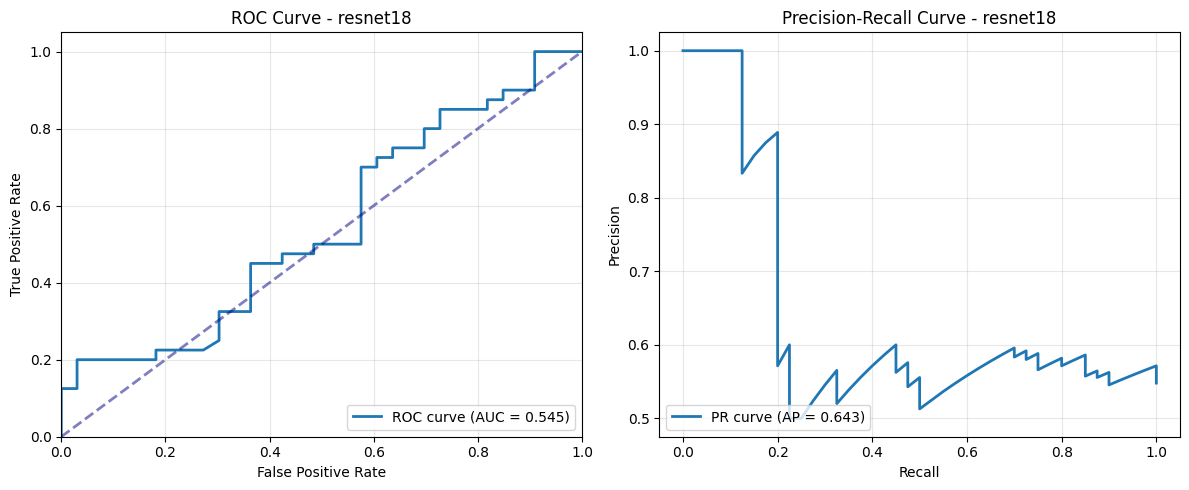

09:25:22 - INFO - Comprehensive evaluation completed for resnet18


INFO:AIVoiceDetection:Comprehensive evaluation completed for resnet18


09:25:22 - INFO - Model training complete: resnet18


INFO:AIVoiceDetection:Model training complete: resnet18


09:25:22 - INFO - Creating model: resnet18


INFO:AIVoiceDetection:Creating model: resnet18


09:25:22 - INFO - Model resnet18 created successfully


INFO:AIVoiceDetection:Model resnet18 created successfully


09:25:22 - INFO - EnhancedEvaluator initialized for resnet18


INFO:AIVoiceDetection:EnhancedEvaluator initialized for resnet18


09:25:22 - INFO - Starting comprehensive evaluation for resnet18


INFO:AIVoiceDetection:Starting comprehensive evaluation for resnet18
Evaluating resnet18: 100%|██████████| 3/3 [00:00<00:00,  5.17it/s]


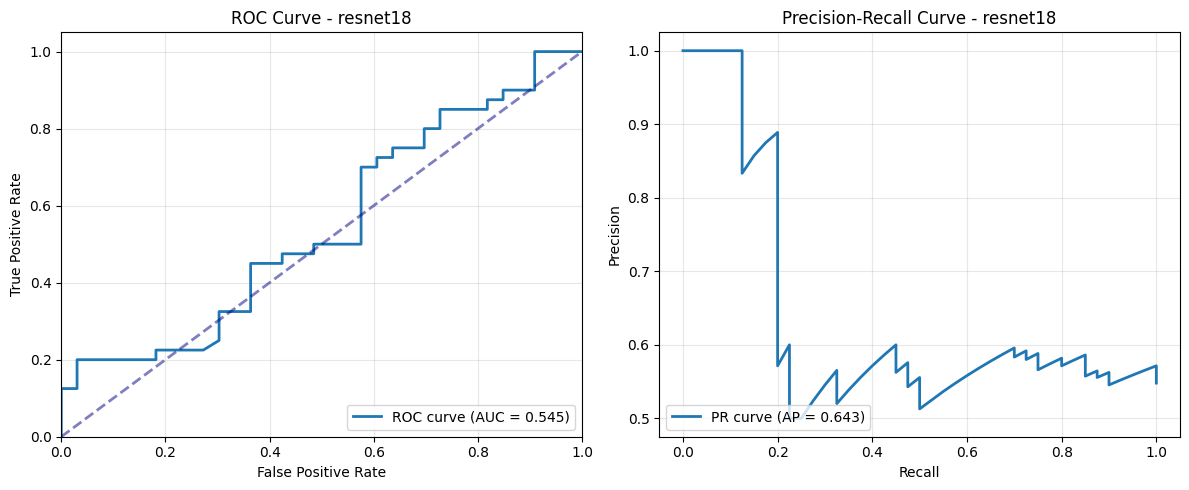

09:25:24 - INFO - Comprehensive evaluation completed for resnet18


INFO:AIVoiceDetection:Comprehensive evaluation completed for resnet18


09:25:24 - INFO - ✓ resnet18 evaluation completed


INFO:AIVoiceDetection:✓ resnet18 evaluation completed


09:25:24 - INFO - Evaluating efficientnet_b0...


INFO:AIVoiceDetection:Evaluating efficientnet_b0...


09:25:24 - INFO - Training efficientnet_b0...


INFO:AIVoiceDetection:Training efficientnet_b0...


09:25:24 - INFO - Initializing WorkflowManager


INFO:AIVoiceDetection:Initializing WorkflowManager


09:25:24 - INFO - Setting up environment...


INFO:AIVoiceDetection:Setting up environment...


09:25:24 - INFO - Random seed set to: 42


INFO:AIVoiceDetection:Random seed set to: 42


09:25:24 - INFO - Device: cuda


INFO:AIVoiceDetection:Device: cuda


09:25:24 - INFO - CUDA available - GPU: Tesla T4


INFO:AIVoiceDetection:CUDA available - GPU: Tesla T4


09:25:24 - INFO - CUDA version: 12.6


INFO:AIVoiceDetection:CUDA version: 12.6


09:25:24 - INFO - Environment setup complete


INFO:AIVoiceDetection:Environment setup complete


09:25:25 - INFO - Demucs model loaded successfully (from pretrained)


INFO:AIVoiceDetection:Demucs model loaded successfully (from pretrained)


09:25:25 - INFO - AudioProcessingPipeline initialized


INFO:AIVoiceDetection:AudioProcessingPipeline initialized


09:25:25 - INFO - DatasetBuilder initialized - base: ./output/spectrogram_images_clean_unique


INFO:AIVoiceDetection:DatasetBuilder initialized - base: ./output/spectrogram_images_clean_unique


09:25:25 - INFO - WorkflowManager ready


INFO:AIVoiceDetection:WorkflowManager ready


09:25:25 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:25 - INFO - Training EFFICIENTNET_B0


INFO:AIVoiceDetection:Training EFFICIENTNET_B0


09:25:25 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:25 - INFO - Creating model: efficientnet_b0


INFO:AIVoiceDetection:Creating model: efficientnet_b0


09:25:25 - INFO - Model efficientnet_b0 created successfully


INFO:AIVoiceDetection:Model efficientnet_b0 created successfully


09:25:25 - INFO - Creating dataloaders...


INFO:AIVoiceDetection:Creating dataloaders...


09:25:25 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


09:25:25 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


09:25:25 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


09:25:25 - INFO - Dataloaders created - batch_size: 32


INFO:AIVoiceDetection:Dataloaders created - batch_size: 32


09:25:25 - INFO - Trainer initialized - Device: cuda, LR: 0.0003


INFO:AIVoiceDetection:Trainer initialized - Device: cuda, LR: 0.0003


09:25:25 - INFO - Starting training - Epochs: 1, Patience: 5


INFO:AIVoiceDetection:Starting training - Epochs: 1, Patience: 5


09:25:25 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:25 - INFO - Epoch 1/1


INFO:AIVoiceDetection:Epoch 1/1


09:25:25 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================
                                                                               

09:25:28 - INFO - Epoch 01 | Train Loss: 0.6322, Acc: 0.628 | Val Loss: 0.7118, Acc: 0.452


INFO:AIVoiceDetection:Epoch 01 | Train Loss: 0.6322, Acc: 0.628 | Val Loss: 0.7118, Acc: 0.452


09:25:28 - INFO - Model improved! Saved to: ./output/spectrogram_images_clean_unique/best_efficientnet_b0_ai_vs_real.pt


INFO:AIVoiceDetection:Model improved! Saved to: ./output/spectrogram_images_clean_unique/best_efficientnet_b0_ai_vs_real.pt


09:25:28 - INFO - Training complete - Best Val Acc: 0.4521


INFO:AIVoiceDetection:Training complete - Best Val Acc: 0.4521


09:25:28 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:28 - INFO - Evaluating EFFICIENTNET_B0 on Test Set


INFO:AIVoiceDetection:Evaluating EFFICIENTNET_B0 on Test Set


09:25:28 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:28 - INFO - EnhancedEvaluator initialized for efficientnet_b0


INFO:AIVoiceDetection:EnhancedEvaluator initialized for efficientnet_b0


09:25:28 - INFO - Starting comprehensive evaluation for efficientnet_b0


INFO:AIVoiceDetection:Starting comprehensive evaluation for efficientnet_b0
Evaluating efficientnet_b0: 100%|██████████| 3/3 [00:00<00:00,  7.52it/s]


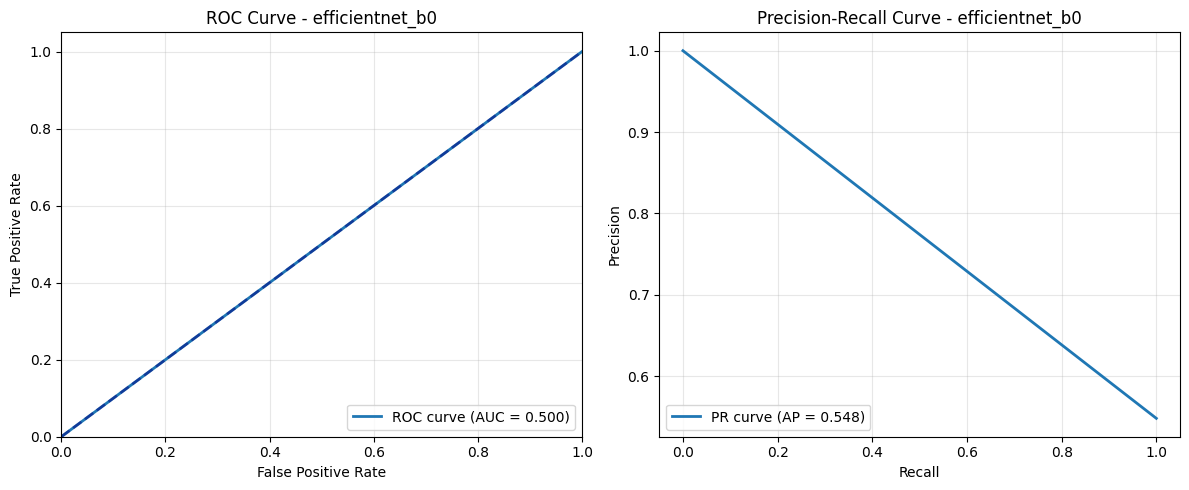

09:25:29 - INFO - Comprehensive evaluation completed for efficientnet_b0


INFO:AIVoiceDetection:Comprehensive evaluation completed for efficientnet_b0


09:25:29 - INFO - Model training complete: efficientnet_b0


INFO:AIVoiceDetection:Model training complete: efficientnet_b0


09:25:29 - INFO - Creating model: efficientnet_b0


INFO:AIVoiceDetection:Creating model: efficientnet_b0


09:25:29 - INFO - Model efficientnet_b0 created successfully


INFO:AIVoiceDetection:Model efficientnet_b0 created successfully


09:25:29 - INFO - EnhancedEvaluator initialized for efficientnet_b0


INFO:AIVoiceDetection:EnhancedEvaluator initialized for efficientnet_b0


09:25:29 - INFO - Starting comprehensive evaluation for efficientnet_b0


INFO:AIVoiceDetection:Starting comprehensive evaluation for efficientnet_b0
Evaluating efficientnet_b0: 100%|██████████| 3/3 [00:00<00:00,  6.99it/s]


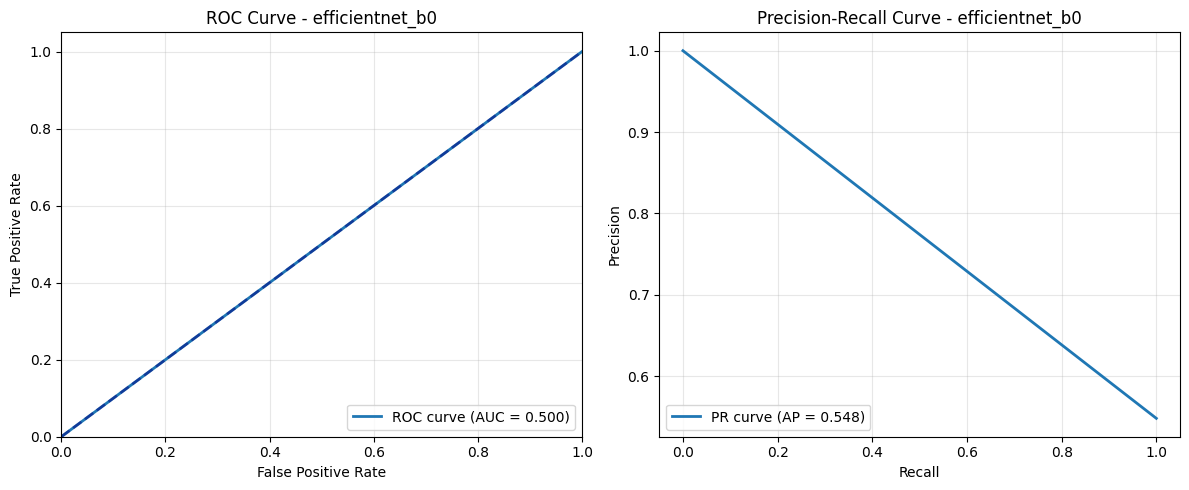

09:25:31 - INFO - Comprehensive evaluation completed for efficientnet_b0


INFO:AIVoiceDetection:Comprehensive evaluation completed for efficientnet_b0


09:25:31 - INFO - ✓ efficientnet_b0 evaluation completed


INFO:AIVoiceDetection:✓ efficientnet_b0 evaluation completed


09:25:31 - INFO - Evaluating densenet121...


INFO:AIVoiceDetection:Evaluating densenet121...


09:25:31 - INFO - Training densenet121...


INFO:AIVoiceDetection:Training densenet121...


09:25:31 - INFO - Initializing WorkflowManager


INFO:AIVoiceDetection:Initializing WorkflowManager


09:25:31 - INFO - Setting up environment...


INFO:AIVoiceDetection:Setting up environment...


09:25:31 - INFO - Random seed set to: 42


INFO:AIVoiceDetection:Random seed set to: 42


09:25:31 - INFO - Device: cuda


INFO:AIVoiceDetection:Device: cuda


09:25:31 - INFO - CUDA available - GPU: Tesla T4


INFO:AIVoiceDetection:CUDA available - GPU: Tesla T4


09:25:31 - INFO - CUDA version: 12.6


INFO:AIVoiceDetection:CUDA version: 12.6


09:25:31 - INFO - Environment setup complete


INFO:AIVoiceDetection:Environment setup complete


09:25:31 - INFO - Demucs model loaded successfully (from pretrained)


INFO:AIVoiceDetection:Demucs model loaded successfully (from pretrained)


09:25:31 - INFO - AudioProcessingPipeline initialized


INFO:AIVoiceDetection:AudioProcessingPipeline initialized


09:25:31 - INFO - DatasetBuilder initialized - base: ./output/spectrogram_images_clean_unique


INFO:AIVoiceDetection:DatasetBuilder initialized - base: ./output/spectrogram_images_clean_unique


09:25:31 - INFO - WorkflowManager ready


INFO:AIVoiceDetection:WorkflowManager ready


09:25:31 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:31 - INFO - Training DENSENET121


INFO:AIVoiceDetection:Training DENSENET121


09:25:31 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:31 - INFO - Creating model: densenet121


INFO:AIVoiceDetection:Creating model: densenet121


09:25:31 - INFO - Model densenet121 created successfully


INFO:AIVoiceDetection:Model densenet121 created successfully


09:25:31 - INFO - Creating dataloaders...


INFO:AIVoiceDetection:Creating dataloaders...


09:25:31 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


09:25:31 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


09:25:31 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


09:25:31 - INFO - Dataloaders created - batch_size: 32


INFO:AIVoiceDetection:Dataloaders created - batch_size: 32


09:25:32 - INFO - Trainer initialized - Device: cuda, LR: 0.0003


INFO:AIVoiceDetection:Trainer initialized - Device: cuda, LR: 0.0003


09:25:32 - INFO - Starting training - Epochs: 1, Patience: 5


INFO:AIVoiceDetection:Starting training - Epochs: 1, Patience: 5


09:25:32 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:32 - INFO - Epoch 1/1


INFO:AIVoiceDetection:Epoch 1/1


09:25:32 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================
                                                                               

09:25:36 - INFO - Epoch 01 | Train Loss: 0.3787, Acc: 0.843 | Val Loss: 1.7712, Acc: 0.452


INFO:AIVoiceDetection:Epoch 01 | Train Loss: 0.3787, Acc: 0.843 | Val Loss: 1.7712, Acc: 0.452


09:25:36 - INFO - Model improved! Saved to: ./output/spectrogram_images_clean_unique/best_densenet121_ai_vs_real.pt


INFO:AIVoiceDetection:Model improved! Saved to: ./output/spectrogram_images_clean_unique/best_densenet121_ai_vs_real.pt


09:25:36 - INFO - Training complete - Best Val Acc: 0.4521


INFO:AIVoiceDetection:Training complete - Best Val Acc: 0.4521


09:25:36 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:36 - INFO - Evaluating DENSENET121 on Test Set


INFO:AIVoiceDetection:Evaluating DENSENET121 on Test Set


09:25:36 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:36 - INFO - EnhancedEvaluator initialized for densenet121


INFO:AIVoiceDetection:EnhancedEvaluator initialized for densenet121


09:25:36 - INFO - Starting comprehensive evaluation for densenet121


INFO:AIVoiceDetection:Starting comprehensive evaluation for densenet121
Evaluating densenet121: 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


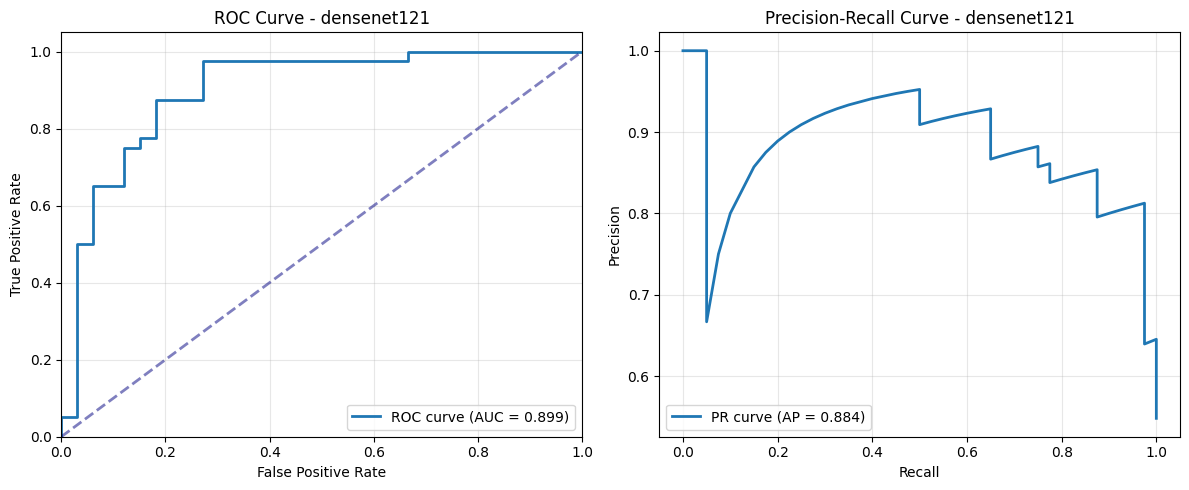

09:25:38 - INFO - Comprehensive evaluation completed for densenet121


INFO:AIVoiceDetection:Comprehensive evaluation completed for densenet121


09:25:38 - INFO - Model training complete: densenet121


INFO:AIVoiceDetection:Model training complete: densenet121


09:25:38 - INFO - Creating model: densenet121


INFO:AIVoiceDetection:Creating model: densenet121


09:25:38 - INFO - Model densenet121 created successfully


INFO:AIVoiceDetection:Model densenet121 created successfully


09:25:38 - INFO - EnhancedEvaluator initialized for densenet121


INFO:AIVoiceDetection:EnhancedEvaluator initialized for densenet121


09:25:38 - INFO - Starting comprehensive evaluation for densenet121


INFO:AIVoiceDetection:Starting comprehensive evaluation for densenet121
Evaluating densenet121: 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]


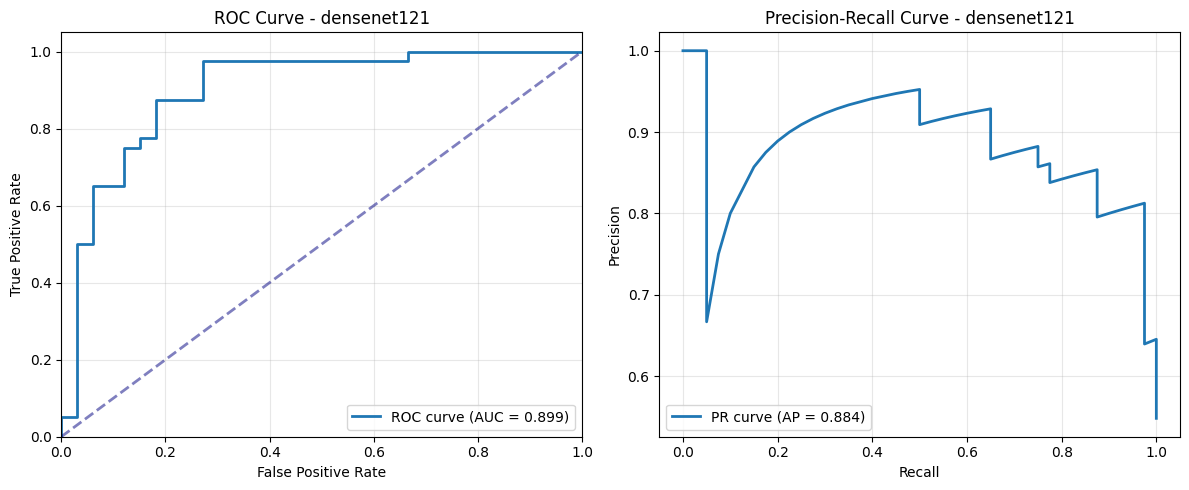

09:25:40 - INFO - Comprehensive evaluation completed for densenet121


INFO:AIVoiceDetection:Comprehensive evaluation completed for densenet121


09:25:40 - INFO - ✓ densenet121 evaluation completed


INFO:AIVoiceDetection:✓ densenet121 evaluation completed


09:25:40 - INFO - Evaluating mobilenet_v3_small...


INFO:AIVoiceDetection:Evaluating mobilenet_v3_small...


09:25:40 - INFO - Training mobilenet_v3_small...


INFO:AIVoiceDetection:Training mobilenet_v3_small...


09:25:40 - INFO - Initializing WorkflowManager


INFO:AIVoiceDetection:Initializing WorkflowManager


09:25:40 - INFO - Setting up environment...


INFO:AIVoiceDetection:Setting up environment...


09:25:40 - INFO - Random seed set to: 42


INFO:AIVoiceDetection:Random seed set to: 42


09:25:40 - INFO - Device: cuda


INFO:AIVoiceDetection:Device: cuda


09:25:40 - INFO - CUDA available - GPU: Tesla T4


INFO:AIVoiceDetection:CUDA available - GPU: Tesla T4


09:25:40 - INFO - CUDA version: 12.6


INFO:AIVoiceDetection:CUDA version: 12.6


09:25:40 - INFO - Environment setup complete


INFO:AIVoiceDetection:Environment setup complete


09:25:40 - INFO - Demucs model loaded successfully (from pretrained)


INFO:AIVoiceDetection:Demucs model loaded successfully (from pretrained)


09:25:40 - INFO - AudioProcessingPipeline initialized


INFO:AIVoiceDetection:AudioProcessingPipeline initialized


09:25:40 - INFO - DatasetBuilder initialized - base: ./output/spectrogram_images_clean_unique


INFO:AIVoiceDetection:DatasetBuilder initialized - base: ./output/spectrogram_images_clean_unique


09:25:40 - INFO - WorkflowManager ready


INFO:AIVoiceDetection:WorkflowManager ready


09:25:40 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:40 - INFO - Training MOBILENET_V3_SMALL


INFO:AIVoiceDetection:Training MOBILENET_V3_SMALL


09:25:40 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:40 - INFO - Creating model: mobilenet_v3_small


INFO:AIVoiceDetection:Creating model: mobilenet_v3_small


09:25:40 - INFO - Model mobilenet_v3_small created successfully


INFO:AIVoiceDetection:Model mobilenet_v3_small created successfully


09:25:40 - INFO - Creating dataloaders...


INFO:AIVoiceDetection:Creating dataloaders...


09:25:40 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


09:25:40 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


09:25:40 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


09:25:40 - INFO - Dataloaders created - batch_size: 32


INFO:AIVoiceDetection:Dataloaders created - batch_size: 32


09:25:40 - INFO - Trainer initialized - Device: cuda, LR: 0.0003


INFO:AIVoiceDetection:Trainer initialized - Device: cuda, LR: 0.0003


09:25:40 - INFO - Starting training - Epochs: 1, Patience: 5


INFO:AIVoiceDetection:Starting training - Epochs: 1, Patience: 5


09:25:40 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:40 - INFO - Epoch 1/1


INFO:AIVoiceDetection:Epoch 1/1


09:25:40 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================
                                                                               

09:25:43 - INFO - Epoch 01 | Train Loss: 0.6349, Acc: 0.616 | Val Loss: 0.6903, Acc: 0.548


INFO:AIVoiceDetection:Epoch 01 | Train Loss: 0.6349, Acc: 0.616 | Val Loss: 0.6903, Acc: 0.548


09:25:43 - INFO - Model improved! Saved to: ./output/spectrogram_images_clean_unique/best_mobilenet_v3_small_ai_vs_real.pt


INFO:AIVoiceDetection:Model improved! Saved to: ./output/spectrogram_images_clean_unique/best_mobilenet_v3_small_ai_vs_real.pt


09:25:43 - INFO - Training complete - Best Val Acc: 0.5479


INFO:AIVoiceDetection:Training complete - Best Val Acc: 0.5479


09:25:43 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:43 - INFO - Evaluating MOBILENET_V3_SMALL on Test Set


INFO:AIVoiceDetection:Evaluating MOBILENET_V3_SMALL on Test Set


09:25:43 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:43 - INFO - EnhancedEvaluator initialized for mobilenet_v3_small


INFO:AIVoiceDetection:EnhancedEvaluator initialized for mobilenet_v3_small


09:25:43 - INFO - Starting comprehensive evaluation for mobilenet_v3_small


INFO:AIVoiceDetection:Starting comprehensive evaluation for mobilenet_v3_small
Evaluating mobilenet_v3_small: 100%|██████████| 3/3 [00:00<00:00,  7.20it/s]


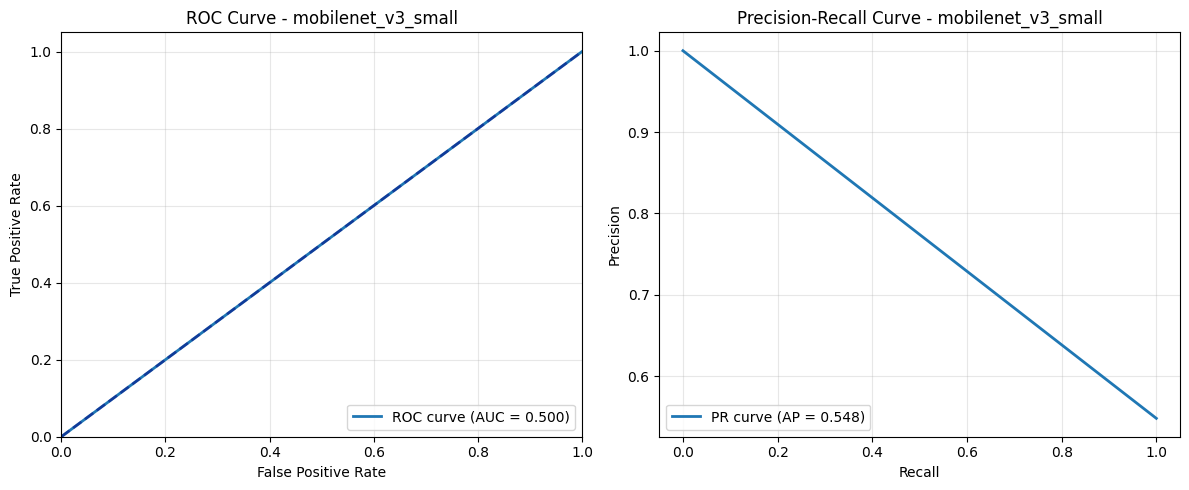

09:25:45 - INFO - Comprehensive evaluation completed for mobilenet_v3_small


INFO:AIVoiceDetection:Comprehensive evaluation completed for mobilenet_v3_small


09:25:45 - INFO - Model training complete: mobilenet_v3_small


INFO:AIVoiceDetection:Model training complete: mobilenet_v3_small


09:25:45 - INFO - Creating model: mobilenet_v3_small


INFO:AIVoiceDetection:Creating model: mobilenet_v3_small


09:25:45 - INFO - Model mobilenet_v3_small created successfully


INFO:AIVoiceDetection:Model mobilenet_v3_small created successfully


09:25:46 - INFO - EnhancedEvaluator initialized for mobilenet_v3_small


INFO:AIVoiceDetection:EnhancedEvaluator initialized for mobilenet_v3_small


09:25:46 - INFO - Starting comprehensive evaluation for mobilenet_v3_small


INFO:AIVoiceDetection:Starting comprehensive evaluation for mobilenet_v3_small
Evaluating mobilenet_v3_small: 100%|██████████| 3/3 [00:00<00:00,  7.16it/s]


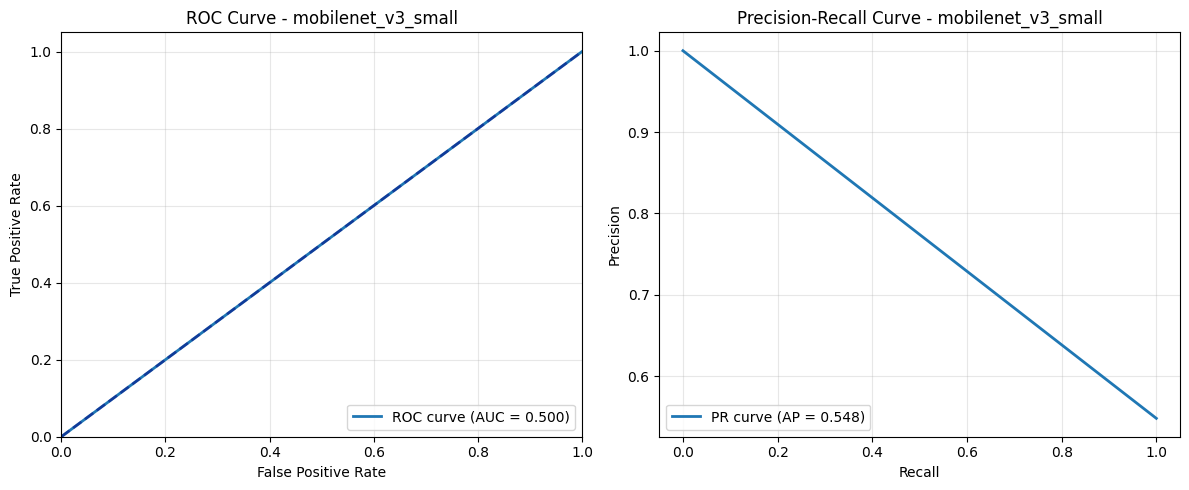

09:25:47 - INFO - Comprehensive evaluation completed for mobilenet_v3_small


INFO:AIVoiceDetection:Comprehensive evaluation completed for mobilenet_v3_small


09:25:47 - INFO - ✓ mobilenet_v3_small evaluation completed


INFO:AIVoiceDetection:✓ mobilenet_v3_small evaluation completed


09:25:47 - INFO - Evaluating convnext_tiny...


INFO:AIVoiceDetection:Evaluating convnext_tiny...


09:25:47 - INFO - Training convnext_tiny...


INFO:AIVoiceDetection:Training convnext_tiny...


09:25:47 - INFO - Initializing WorkflowManager


INFO:AIVoiceDetection:Initializing WorkflowManager


09:25:47 - INFO - Setting up environment...


INFO:AIVoiceDetection:Setting up environment...


09:25:47 - INFO - Random seed set to: 42


INFO:AIVoiceDetection:Random seed set to: 42


09:25:47 - INFO - Device: cuda


INFO:AIVoiceDetection:Device: cuda


09:25:47 - INFO - CUDA available - GPU: Tesla T4


INFO:AIVoiceDetection:CUDA available - GPU: Tesla T4


09:25:47 - INFO - CUDA version: 12.6


INFO:AIVoiceDetection:CUDA version: 12.6


09:25:47 - INFO - Environment setup complete


INFO:AIVoiceDetection:Environment setup complete


09:25:47 - INFO - Demucs model loaded successfully (from pretrained)


INFO:AIVoiceDetection:Demucs model loaded successfully (from pretrained)


09:25:47 - INFO - AudioProcessingPipeline initialized


INFO:AIVoiceDetection:AudioProcessingPipeline initialized


09:25:47 - INFO - DatasetBuilder initialized - base: ./output/spectrogram_images_clean_unique


INFO:AIVoiceDetection:DatasetBuilder initialized - base: ./output/spectrogram_images_clean_unique


09:25:47 - INFO - WorkflowManager ready


INFO:AIVoiceDetection:WorkflowManager ready


09:25:47 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:47 - INFO - Training CONVNEXT_TINY


INFO:AIVoiceDetection:Training CONVNEXT_TINY


09:25:47 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:47 - INFO - Creating model: convnext_tiny


INFO:AIVoiceDetection:Creating model: convnext_tiny


09:25:48 - INFO - Model convnext_tiny created successfully


INFO:AIVoiceDetection:Model convnext_tiny created successfully


09:25:48 - INFO - Creating dataloaders...


INFO:AIVoiceDetection:Creating dataloaders...


09:25:48 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


09:25:48 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


09:25:48 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


09:25:48 - INFO - Dataloaders created - batch_size: 32


INFO:AIVoiceDetection:Dataloaders created - batch_size: 32


09:25:48 - INFO - Trainer initialized - Device: cuda, LR: 0.0003


INFO:AIVoiceDetection:Trainer initialized - Device: cuda, LR: 0.0003


09:25:48 - INFO - Starting training - Epochs: 1, Patience: 5


INFO:AIVoiceDetection:Starting training - Epochs: 1, Patience: 5


09:25:48 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:48 - INFO - Epoch 1/1


INFO:AIVoiceDetection:Epoch 1/1


09:25:48 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================
                                                                               

09:25:52 - INFO - Epoch 01 | Train Loss: 1.1468, Acc: 0.576 | Val Loss: 0.9000, Acc: 0.521


INFO:AIVoiceDetection:Epoch 01 | Train Loss: 1.1468, Acc: 0.576 | Val Loss: 0.9000, Acc: 0.521


09:25:53 - INFO - Model improved! Saved to: ./output/spectrogram_images_clean_unique/best_convnext_tiny_ai_vs_real.pt


INFO:AIVoiceDetection:Model improved! Saved to: ./output/spectrogram_images_clean_unique/best_convnext_tiny_ai_vs_real.pt


09:25:53 - INFO - Training complete - Best Val Acc: 0.5205


INFO:AIVoiceDetection:Training complete - Best Val Acc: 0.5205


09:25:53 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:53 - INFO - Evaluating CONVNEXT_TINY on Test Set


INFO:AIVoiceDetection:Evaluating CONVNEXT_TINY on Test Set


09:25:53 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:53 - INFO - EnhancedEvaluator initialized for convnext_tiny


INFO:AIVoiceDetection:EnhancedEvaluator initialized for convnext_tiny


09:25:53 - INFO - Starting comprehensive evaluation for convnext_tiny


INFO:AIVoiceDetection:Starting comprehensive evaluation for convnext_tiny
Evaluating convnext_tiny: 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]


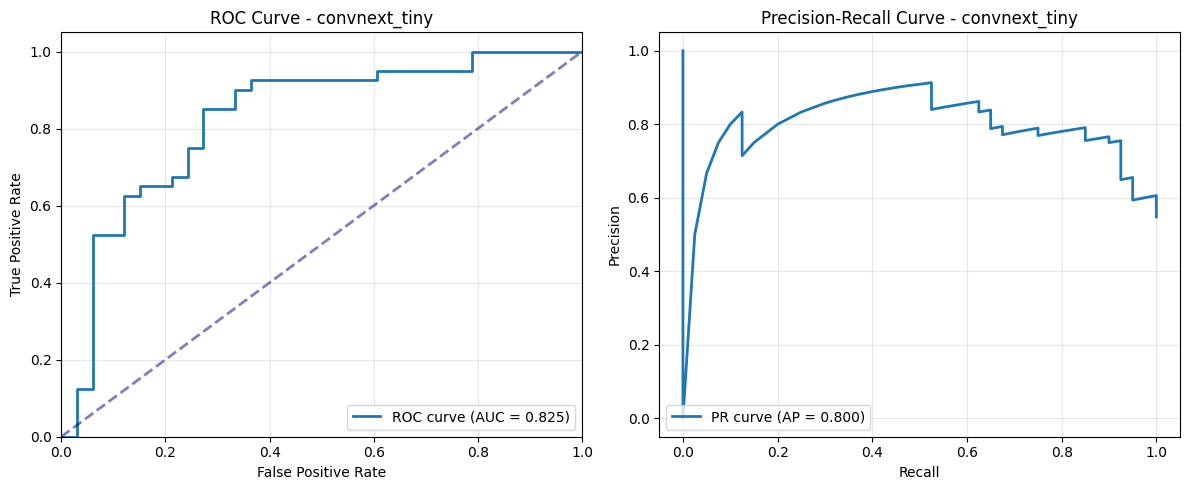

09:25:55 - INFO - Comprehensive evaluation completed for convnext_tiny


INFO:AIVoiceDetection:Comprehensive evaluation completed for convnext_tiny


09:25:55 - INFO - Model training complete: convnext_tiny


INFO:AIVoiceDetection:Model training complete: convnext_tiny


09:25:55 - INFO - Creating model: convnext_tiny


INFO:AIVoiceDetection:Creating model: convnext_tiny


09:25:55 - INFO - Model convnext_tiny created successfully


INFO:AIVoiceDetection:Model convnext_tiny created successfully


09:25:55 - INFO - EnhancedEvaluator initialized for convnext_tiny


INFO:AIVoiceDetection:EnhancedEvaluator initialized for convnext_tiny


09:25:55 - INFO - Starting comprehensive evaluation for convnext_tiny


INFO:AIVoiceDetection:Starting comprehensive evaluation for convnext_tiny
Evaluating convnext_tiny: 100%|██████████| 3/3 [00:00<00:00,  5.58it/s]


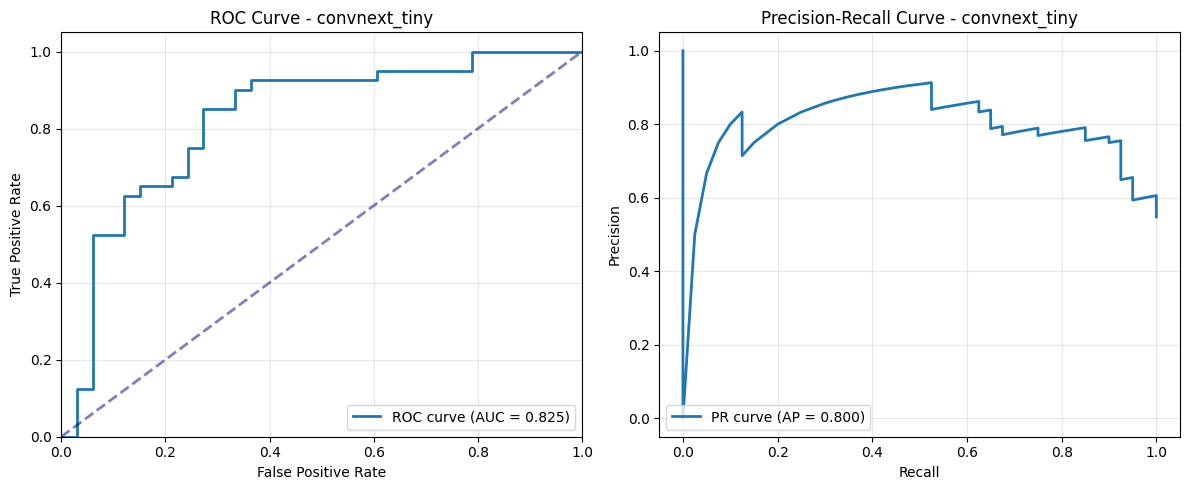

09:25:57 - INFO - Comprehensive evaluation completed for convnext_tiny


INFO:AIVoiceDetection:Comprehensive evaluation completed for convnext_tiny


09:25:57 - INFO - ✓ convnext_tiny evaluation completed


INFO:AIVoiceDetection:✓ convnext_tiny evaluation completed


09:25:57 - INFO - Evaluating vit_b16...


INFO:AIVoiceDetection:Evaluating vit_b16...


09:25:57 - INFO - Training vit_b16...


INFO:AIVoiceDetection:Training vit_b16...


09:25:57 - INFO - Initializing WorkflowManager


INFO:AIVoiceDetection:Initializing WorkflowManager


09:25:57 - INFO - Setting up environment...


INFO:AIVoiceDetection:Setting up environment...


09:25:57 - INFO - Random seed set to: 42


INFO:AIVoiceDetection:Random seed set to: 42


09:25:57 - INFO - Device: cuda


INFO:AIVoiceDetection:Device: cuda


09:25:57 - INFO - CUDA available - GPU: Tesla T4


INFO:AIVoiceDetection:CUDA available - GPU: Tesla T4


09:25:57 - INFO - CUDA version: 12.6


INFO:AIVoiceDetection:CUDA version: 12.6


09:25:57 - INFO - Environment setup complete


INFO:AIVoiceDetection:Environment setup complete


09:25:57 - INFO - Demucs model loaded successfully (from pretrained)


INFO:AIVoiceDetection:Demucs model loaded successfully (from pretrained)


09:25:57 - INFO - AudioProcessingPipeline initialized


INFO:AIVoiceDetection:AudioProcessingPipeline initialized


09:25:57 - INFO - DatasetBuilder initialized - base: ./output/spectrogram_images_clean_unique


INFO:AIVoiceDetection:DatasetBuilder initialized - base: ./output/spectrogram_images_clean_unique


09:25:57 - INFO - WorkflowManager ready


INFO:AIVoiceDetection:WorkflowManager ready


09:25:57 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:57 - INFO - Training VIT_B16


INFO:AIVoiceDetection:Training VIT_B16


09:25:57 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:57 - INFO - Creating model: vit_b16


INFO:AIVoiceDetection:Creating model: vit_b16


09:25:58 - INFO - Model vit_b16 created successfully


INFO:AIVoiceDetection:Model vit_b16 created successfully


09:25:58 - INFO - Creating dataloaders...


INFO:AIVoiceDetection:Creating dataloaders...


09:25:58 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


09:25:58 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


09:25:58 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


09:25:58 - INFO - Dataloaders created - batch_size: 32


INFO:AIVoiceDetection:Dataloaders created - batch_size: 32


09:25:58 - INFO - Trainer initialized - Device: cuda, LR: 0.0003


INFO:AIVoiceDetection:Trainer initialized - Device: cuda, LR: 0.0003


09:25:58 - INFO - Starting training - Epochs: 1, Patience: 5


INFO:AIVoiceDetection:Starting training - Epochs: 1, Patience: 5


09:25:58 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:25:58 - INFO - Epoch 1/1


INFO:AIVoiceDetection:Epoch 1/1


09:25:58 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================
                                                                               

09:26:07 - INFO - Epoch 01 | Train Loss: 1.6668, Acc: 0.562 | Val Loss: 0.6384, Acc: 0.671


INFO:AIVoiceDetection:Epoch 01 | Train Loss: 1.6668, Acc: 0.562 | Val Loss: 0.6384, Acc: 0.671


09:26:07 - INFO - Model improved! Saved to: ./output/spectrogram_images_clean_unique/best_vit_b16_ai_vs_real.pt


INFO:AIVoiceDetection:Model improved! Saved to: ./output/spectrogram_images_clean_unique/best_vit_b16_ai_vs_real.pt


09:26:07 - INFO - Training complete - Best Val Acc: 0.6712


INFO:AIVoiceDetection:Training complete - Best Val Acc: 0.6712


09:26:07 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:26:07 - INFO - Evaluating VIT_B16 on Test Set


INFO:AIVoiceDetection:Evaluating VIT_B16 on Test Set


09:26:07 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:26:08 - INFO - EnhancedEvaluator initialized for vit_b16


INFO:AIVoiceDetection:EnhancedEvaluator initialized for vit_b16


09:26:08 - INFO - Starting comprehensive evaluation for vit_b16


INFO:AIVoiceDetection:Starting comprehensive evaluation for vit_b16
Evaluating vit_b16: 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]


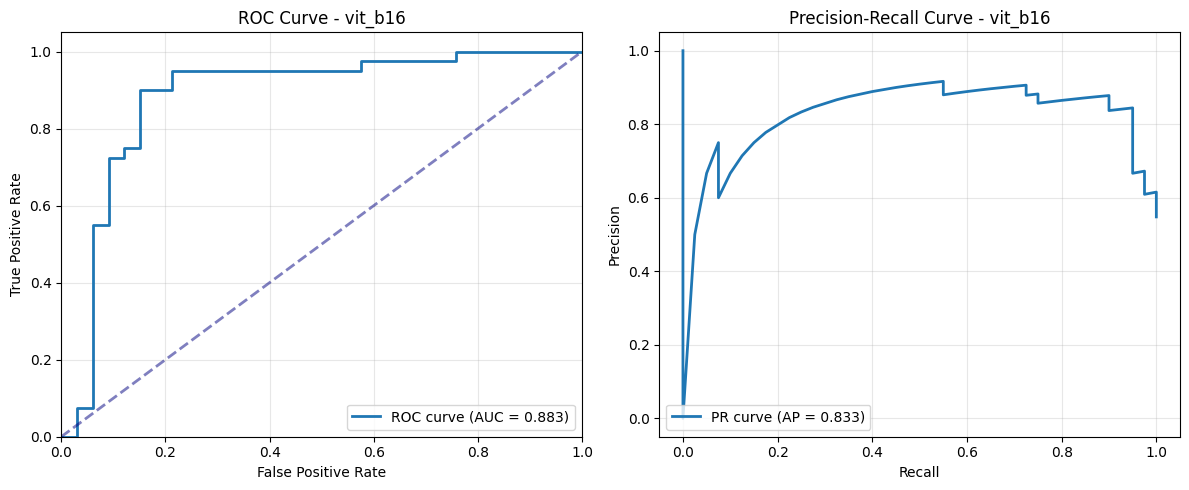

09:26:09 - INFO - Comprehensive evaluation completed for vit_b16


INFO:AIVoiceDetection:Comprehensive evaluation completed for vit_b16


09:26:09 - INFO - Model training complete: vit_b16


INFO:AIVoiceDetection:Model training complete: vit_b16


09:26:09 - INFO - Creating model: vit_b16


INFO:AIVoiceDetection:Creating model: vit_b16


09:26:10 - INFO - Model vit_b16 created successfully


INFO:AIVoiceDetection:Model vit_b16 created successfully


09:26:10 - INFO - EnhancedEvaluator initialized for vit_b16


INFO:AIVoiceDetection:EnhancedEvaluator initialized for vit_b16


09:26:10 - INFO - Starting comprehensive evaluation for vit_b16


INFO:AIVoiceDetection:Starting comprehensive evaluation for vit_b16
Evaluating vit_b16: 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


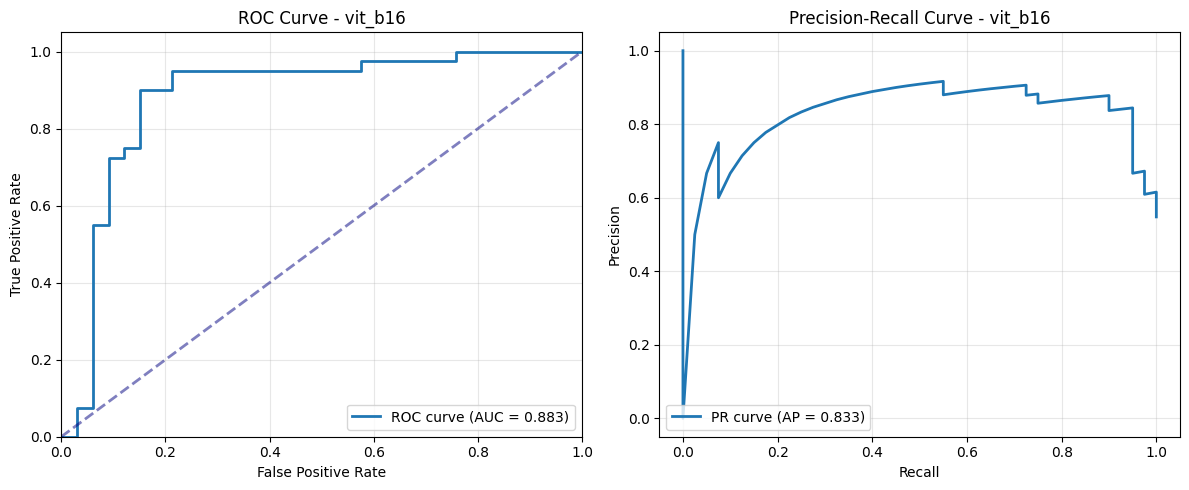

09:26:12 - INFO - Comprehensive evaluation completed for vit_b16


INFO:AIVoiceDetection:Comprehensive evaluation completed for vit_b16


09:26:12 - INFO - ✓ vit_b16 evaluation completed


INFO:AIVoiceDetection:✓ vit_b16 evaluation completed


09:26:12 - INFO - Evaluating swin_tiny...


INFO:AIVoiceDetection:Evaluating swin_tiny...


09:26:12 - INFO - Training swin_tiny...


INFO:AIVoiceDetection:Training swin_tiny...


09:26:12 - INFO - Initializing WorkflowManager


INFO:AIVoiceDetection:Initializing WorkflowManager


09:26:12 - INFO - Setting up environment...


INFO:AIVoiceDetection:Setting up environment...


09:26:12 - INFO - Random seed set to: 42


INFO:AIVoiceDetection:Random seed set to: 42


09:26:12 - INFO - Device: cuda


INFO:AIVoiceDetection:Device: cuda


09:26:12 - INFO - CUDA available - GPU: Tesla T4


INFO:AIVoiceDetection:CUDA available - GPU: Tesla T4


09:26:12 - INFO - CUDA version: 12.6


INFO:AIVoiceDetection:CUDA version: 12.6


09:26:12 - INFO - Environment setup complete


INFO:AIVoiceDetection:Environment setup complete


09:26:13 - INFO - Demucs model loaded successfully (from pretrained)


INFO:AIVoiceDetection:Demucs model loaded successfully (from pretrained)


09:26:13 - INFO - AudioProcessingPipeline initialized


INFO:AIVoiceDetection:AudioProcessingPipeline initialized


09:26:13 - INFO - DatasetBuilder initialized - base: ./output/spectrogram_images_clean_unique


INFO:AIVoiceDetection:DatasetBuilder initialized - base: ./output/spectrogram_images_clean_unique


09:26:13 - INFO - WorkflowManager ready


INFO:AIVoiceDetection:WorkflowManager ready


09:26:13 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:26:13 - INFO - Training SWIN_TINY


INFO:AIVoiceDetection:Training SWIN_TINY


09:26:13 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:26:13 - INFO - Creating model: swin_tiny


INFO:AIVoiceDetection:Creating model: swin_tiny


09:26:13 - INFO - Model swin_tiny created successfully


INFO:AIVoiceDetection:Model swin_tiny created successfully


09:26:13 - INFO - Creating dataloaders...


INFO:AIVoiceDetection:Creating dataloaders...


09:26:13 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


09:26:13 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


09:26:13 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


09:26:13 - INFO - Dataloaders created - batch_size: 32


INFO:AIVoiceDetection:Dataloaders created - batch_size: 32


09:26:13 - INFO - Trainer initialized - Device: cuda, LR: 0.0003


INFO:AIVoiceDetection:Trainer initialized - Device: cuda, LR: 0.0003


09:26:13 - INFO - Starting training - Epochs: 1, Patience: 5


INFO:AIVoiceDetection:Starting training - Epochs: 1, Patience: 5


09:26:13 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:26:13 - INFO - Epoch 1/1


INFO:AIVoiceDetection:Epoch 1/1


09:26:13 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:26:18 - INFO - Epoch 01 | Train Loss: 1.6988, Acc: 0.562 | Val Loss: 0.6248, Acc: 0.671


INFO:AIVoiceDetection:Epoch 01 | Train Loss: 1.6988, Acc: 0.562 | Val Loss: 0.6248, Acc: 0.671


09:26:19 - INFO - Model improved! Saved to: ./output/spectrogram_images_clean_unique/best_swin_tiny_ai_vs_real.pt


INFO:AIVoiceDetection:Model improved! Saved to: ./output/spectrogram_images_clean_unique/best_swin_tiny_ai_vs_real.pt


09:26:19 - INFO - Training complete - Best Val Acc: 0.6712


INFO:AIVoiceDetection:Training complete - Best Val Acc: 0.6712


09:26:19 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:26:19 - INFO - Evaluating SWIN_TINY on Test Set


INFO:AIVoiceDetection:Evaluating SWIN_TINY on Test Set


09:26:19 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:26:19 - INFO - EnhancedEvaluator initialized for swin_tiny


INFO:AIVoiceDetection:EnhancedEvaluator initialized for swin_tiny


09:26:19 - INFO - Starting comprehensive evaluation for swin_tiny


INFO:AIVoiceDetection:Starting comprehensive evaluation for swin_tiny
Evaluating swin_tiny: 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]


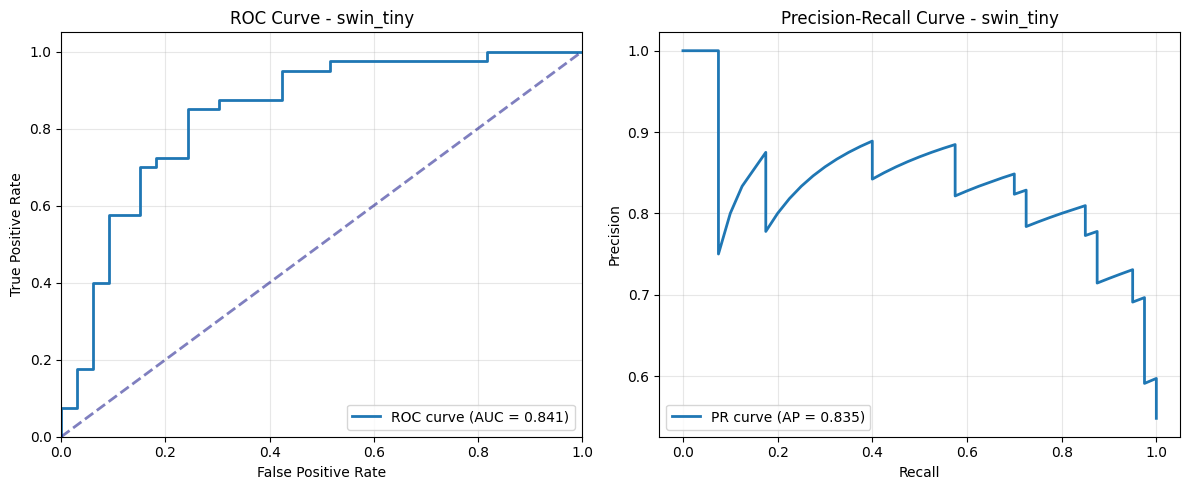

09:26:20 - INFO - Comprehensive evaluation completed for swin_tiny


INFO:AIVoiceDetection:Comprehensive evaluation completed for swin_tiny


09:26:20 - INFO - Model training complete: swin_tiny


INFO:AIVoiceDetection:Model training complete: swin_tiny


09:26:20 - INFO - Creating model: swin_tiny


INFO:AIVoiceDetection:Creating model: swin_tiny


09:26:21 - INFO - Model swin_tiny created successfully


INFO:AIVoiceDetection:Model swin_tiny created successfully


09:26:21 - INFO - EnhancedEvaluator initialized for swin_tiny


INFO:AIVoiceDetection:EnhancedEvaluator initialized for swin_tiny


09:26:21 - INFO - Starting comprehensive evaluation for swin_tiny


INFO:AIVoiceDetection:Starting comprehensive evaluation for swin_tiny
Evaluating swin_tiny: 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


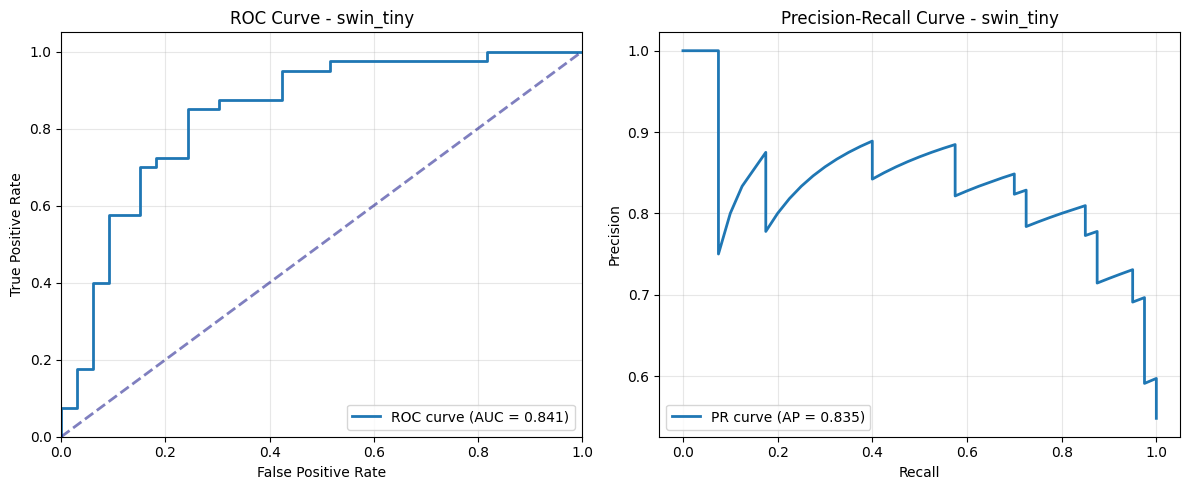

09:26:22 - INFO - Comprehensive evaluation completed for swin_tiny


INFO:AIVoiceDetection:Comprehensive evaluation completed for swin_tiny


09:26:22 - INFO - ✓ swin_tiny evaluation completed


INFO:AIVoiceDetection:✓ swin_tiny evaluation completed


09:26:22 - INFO - Generating model comparison report...


INFO:AIVoiceDetection:Generating model comparison report...


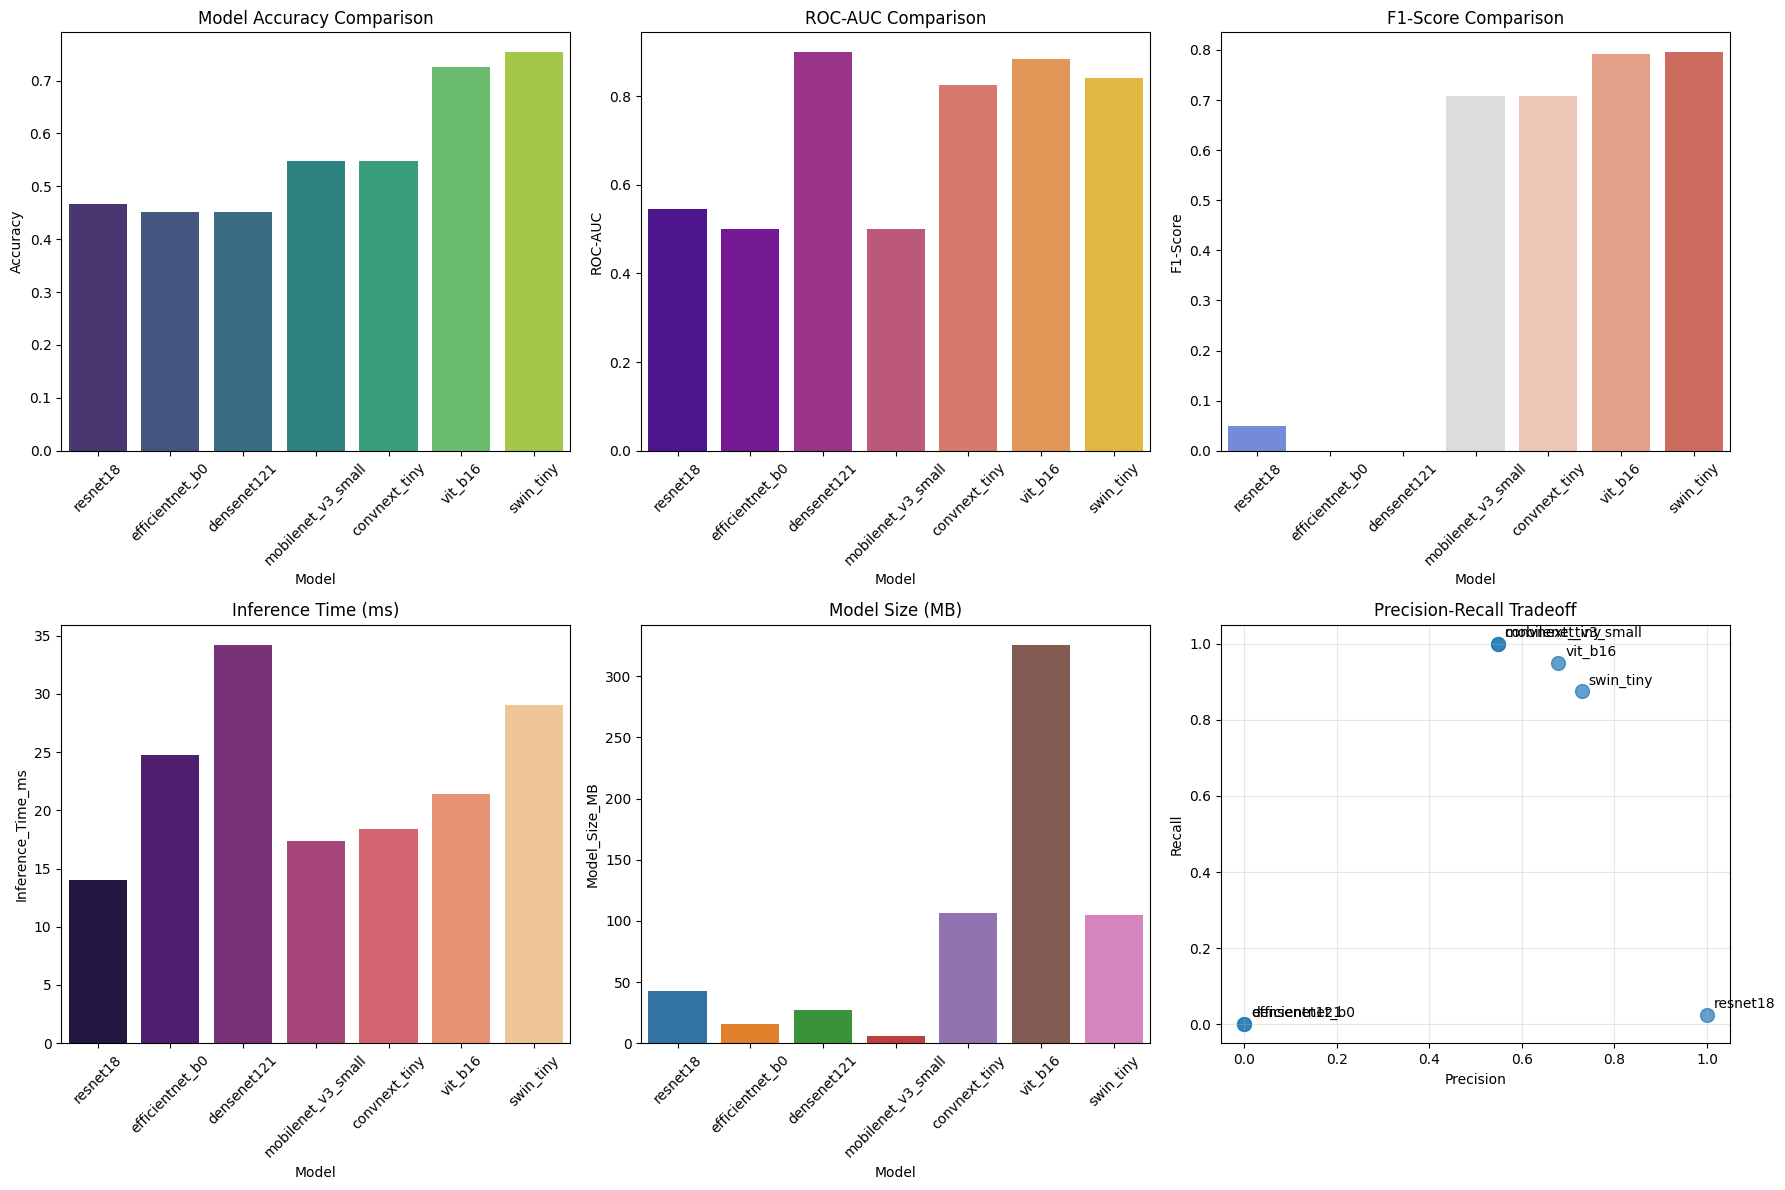

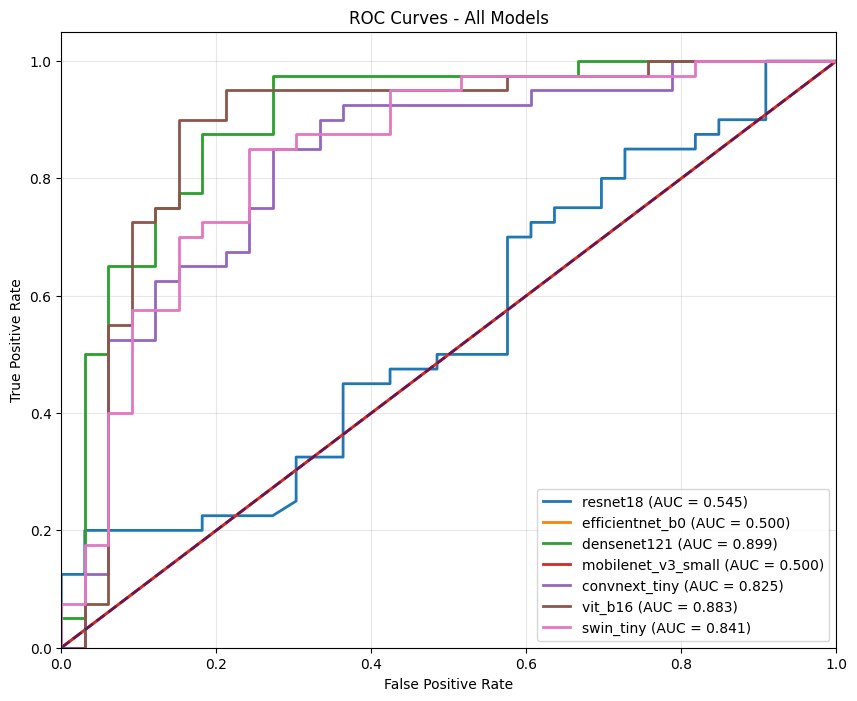

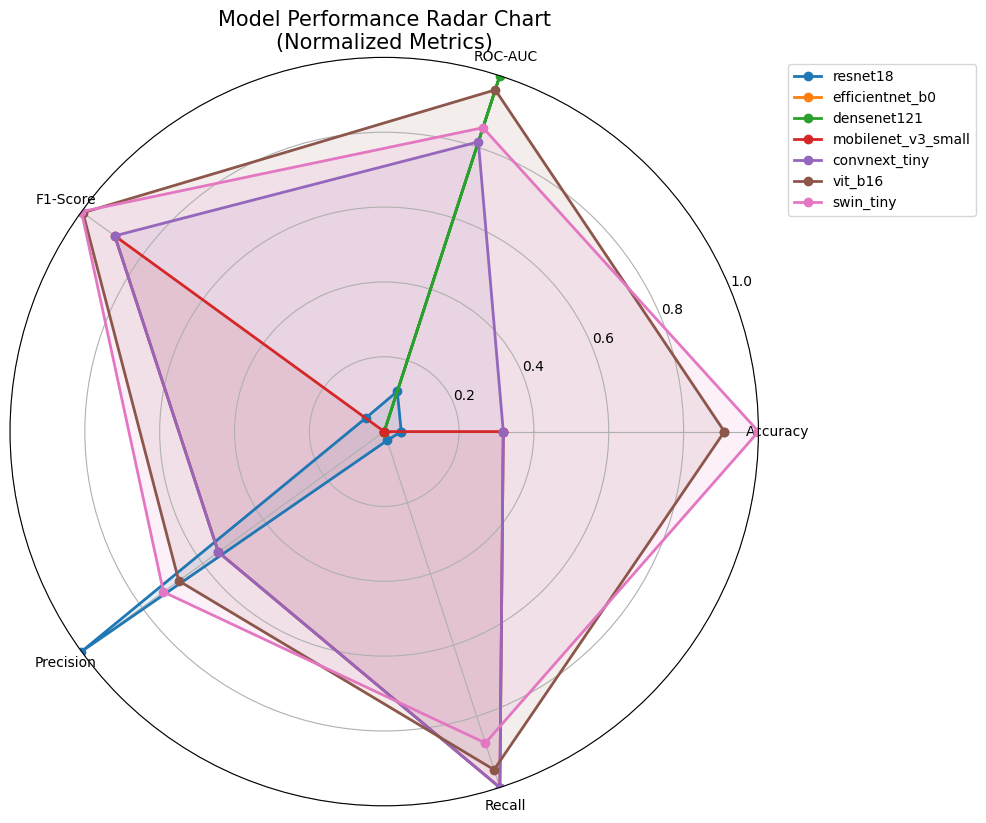


MODEL COMPARISON SUMMARY
             Model  Accuracy  ROC-AUC  F1-Score  Precision  Recall  Inference_Time_ms  Model_Size_MB
          resnet18    0.4658   0.5451    0.0488     1.0000   0.025            13.9992        42.6518
   efficientnet_b0    0.4521   0.5000    0.0000     0.0000   0.000            24.7307        15.4558
       densenet121    0.4521   0.8992    0.0000     0.0000   0.000            34.2083        26.8308
mobilenet_v3_small    0.5479   0.5000    0.7080     0.5479   1.000            17.3815         5.8433
     convnext_tiny    0.5479   0.8250    0.7080     0.5479   1.000            18.4292       106.1195
           vit_b16    0.7260   0.8833    0.7917     0.6786   0.950            21.3583       325.8018
         swin_tiny    0.7534   0.8409    0.7955     0.7292   0.875            29.0023       105.1920

BEST MODELS BY METRIC:
Accuracy: swin_tiny (0.7534)
ROC-AUC: densenet121 (0.8992)
F1-Score: swin_tiny (0.7955)
Fastest: resnet18 (14.00 ms)
Smallest: mobilenet_v3_sm

INFO:AIVoiceDetection:Model comparison report generated


09:26:27 - INFO - Step 3: Hybrid Ensemble Training


INFO:AIVoiceDetection:Step 3: Hybrid Ensemble Training


09:26:27 - INFO - Training hybrid_ensemble ensemble...


INFO:AIVoiceDetection:Training hybrid_ensemble ensemble...


09:26:27 - INFO - Creating model: resnet18


INFO:AIVoiceDetection:Creating model: resnet18


09:26:27 - INFO - Model resnet18 created successfully


INFO:AIVoiceDetection:Model resnet18 created successfully


09:26:27 - INFO - Creating model: efficientnet_b0


INFO:AIVoiceDetection:Creating model: efficientnet_b0


09:26:27 - INFO - Model efficientnet_b0 created successfully


INFO:AIVoiceDetection:Model efficientnet_b0 created successfully


09:26:28 - INFO - Creating model: convnext_tiny


INFO:AIVoiceDetection:Creating model: convnext_tiny


09:26:28 - INFO - Model convnext_tiny created successfully


INFO:AIVoiceDetection:Model convnext_tiny created successfully


09:26:28 - INFO - EnhancedEnsembleModel created with 3 models


INFO:AIVoiceDetection:EnhancedEnsembleModel created with 3 models


09:26:28 - INFO - Creating dataloaders...


INFO:AIVoiceDetection:Creating dataloaders...


09:26:28 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


09:26:28 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


09:26:28 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


09:26:28 - INFO - Dataloaders created - batch_size: 32


INFO:AIVoiceDetection:Dataloaders created - batch_size: 32


09:26:28 - INFO - Trainer initialized - Device: cuda, LR: 0.0003


INFO:AIVoiceDetection:Trainer initialized - Device: cuda, LR: 0.0003


09:26:28 - INFO - Starting training - Epochs: 1, Patience: 5


INFO:AIVoiceDetection:Starting training - Epochs: 1, Patience: 5


09:26:28 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================


09:26:28 - INFO - Epoch 1/1


INFO:AIVoiceDetection:Epoch 1/1


09:26:28 - INFO - ============================================================


INFO:AIVoiceDetection:============================================================
                                                                               

09:26:32 - INFO - Epoch 01 | Train Loss: 0.7172, Acc: 0.572 | Val Loss: 0.6723, Acc: 0.548


INFO:AIVoiceDetection:Epoch 01 | Train Loss: 0.7172, Acc: 0.572 | Val Loss: 0.6723, Acc: 0.548


09:26:33 - INFO - Model improved! Saved to: ./output/spectrogram_images_clean_unique/best_hybrid_ensemble_ensemble.pt


INFO:AIVoiceDetection:Model improved! Saved to: ./output/spectrogram_images_clean_unique/best_hybrid_ensemble_ensemble.pt


09:26:33 - INFO - Training complete - Best Val Acc: 0.5479


INFO:AIVoiceDetection:Training complete - Best Val Acc: 0.5479


09:26:33 - INFO - EnhancedEvaluator initialized for hybrid_ensemble_ensemble


INFO:AIVoiceDetection:EnhancedEvaluator initialized for hybrid_ensemble_ensemble


09:26:33 - INFO - Starting comprehensive evaluation for hybrid_ensemble_ensemble


INFO:AIVoiceDetection:Starting comprehensive evaluation for hybrid_ensemble_ensemble
Evaluating hybrid_ensemble_ensemble: 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]


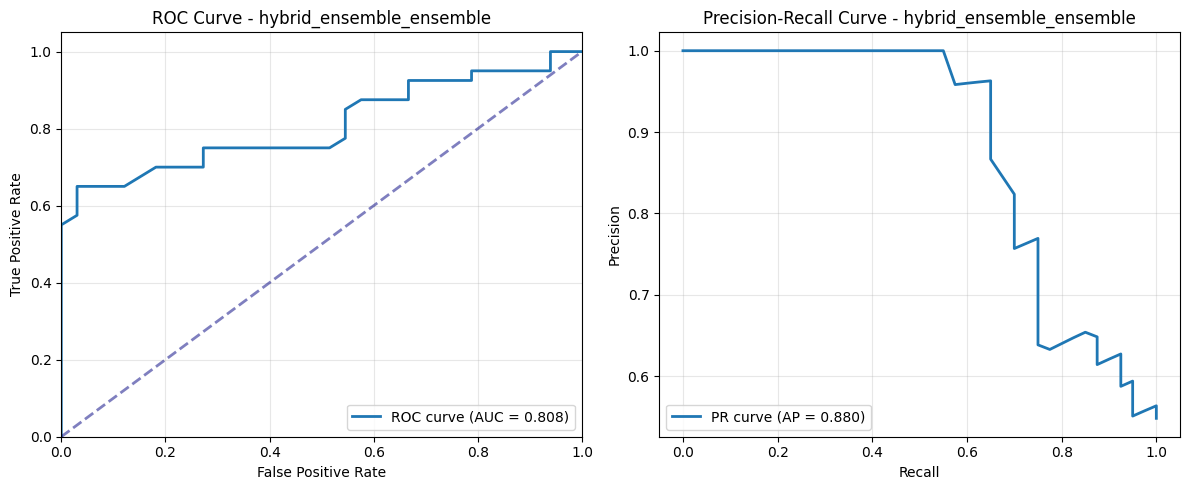

09:26:35 - INFO - Comprehensive evaluation completed for hybrid_ensemble_ensemble


INFO:AIVoiceDetection:Comprehensive evaluation completed for hybrid_ensemble_ensemble


09:26:35 - INFO - Analyzing ensemble contributions...


INFO:AIVoiceDetection:Analyzing ensemble contributions...
Analyzing contributions: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


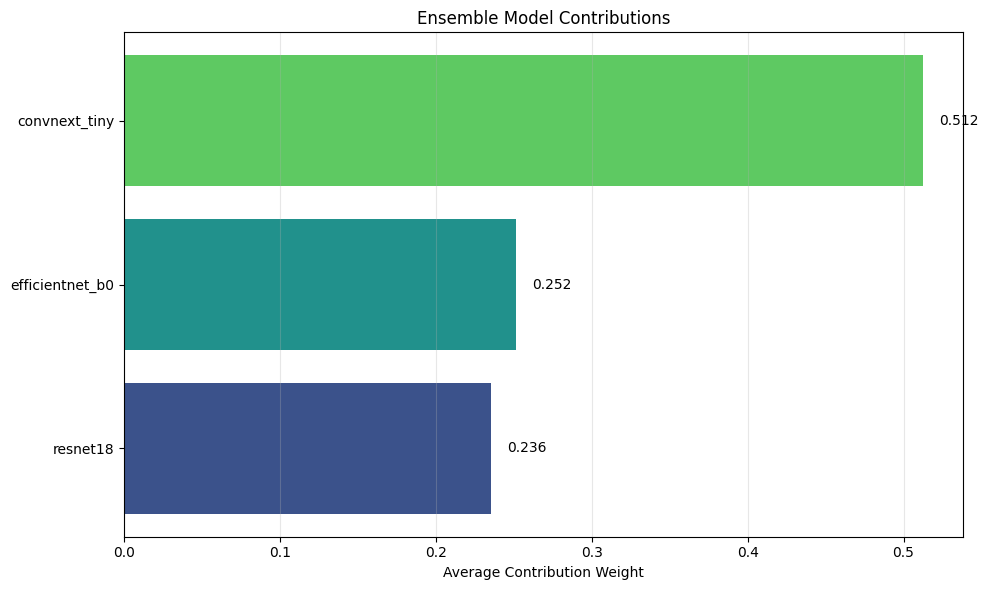


Ensemble Model Contributions:
  resnet18: 0.2358
  efficientnet_b0: 0.2517
  convnext_tiny: 0.5125
09:26:36 - INFO - Hybrid ensemble training completed: hybrid_ensemble


INFO:AIVoiceDetection:Hybrid ensemble training completed: hybrid_ensemble


09:26:36 - INFO - Step 4: XAI Analysis


INFO:AIVoiceDetection:Step 4: XAI Analysis


09:26:36 - INFO - Performing XAI analysis...


INFO:AIVoiceDetection:Performing XAI analysis...


09:26:36 - INFO - Performing XAI on best model: densenet121 (AUC: 0.8992)


INFO:AIVoiceDetection:Performing XAI on best model: densenet121 (AUC: 0.8992)


09:26:36 - INFO - Creating model: densenet121


INFO:AIVoiceDetection:Creating model: densenet121


09:26:36 - INFO - Model densenet121 created successfully


INFO:AIVoiceDetection:Model densenet121 created successfully


09:26:36 - INFO - Creating dataloaders...


INFO:AIVoiceDetection:Creating dataloaders...


09:26:36 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/train.csv: 580 samples


09:26:36 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/val.csv: 73 samples


09:26:36 - INFO - Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


INFO:AIVoiceDetection:Dataset loaded from ./output/spectrogram_images_clean_unique/_splits/test.csv: 73 samples


09:26:36 - INFO - Dataloaders created - batch_size: 32


INFO:AIVoiceDetection:Dataloaders created - batch_size: 32


09:26:37 - INFO - XAIAnalyzer initialized


INFO:AIVoiceDetection:XAIAnalyzer initialized


09:26:37 - INFO - Generating comprehensive XAI report for densenet121


INFO:AIVoiceDetection:Generating comprehensive XAI report for densenet121


Prediction: Real (confidence: 0.9038)


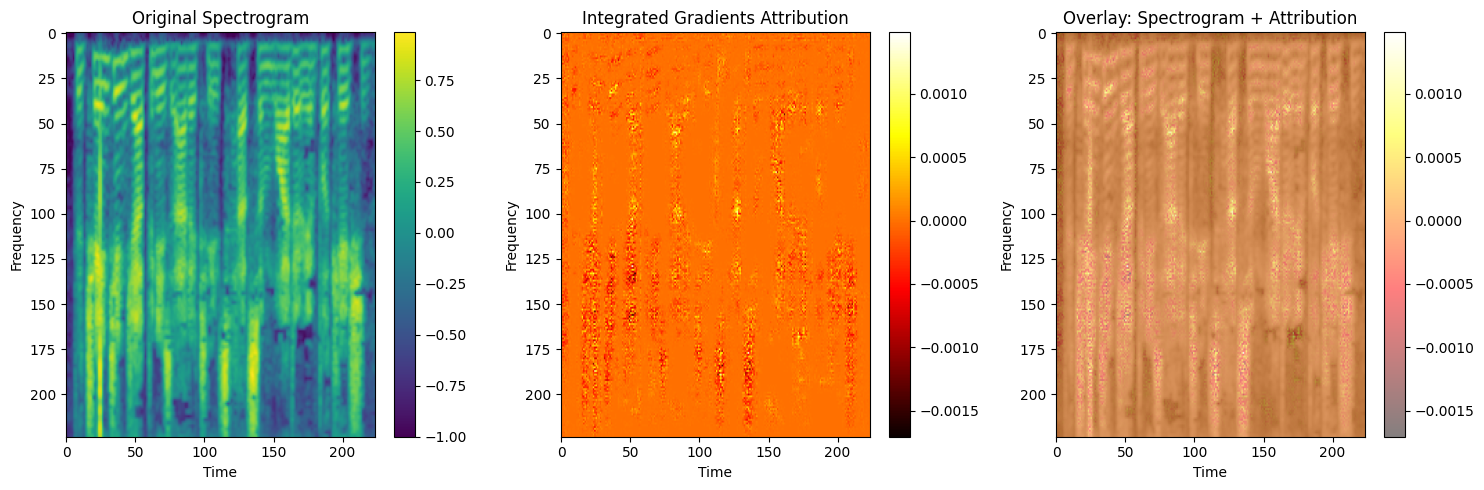

09:26:39 - INFO - Integrated Gradients analysis completed


INFO:AIVoiceDetection:Integrated Gradients analysis completed


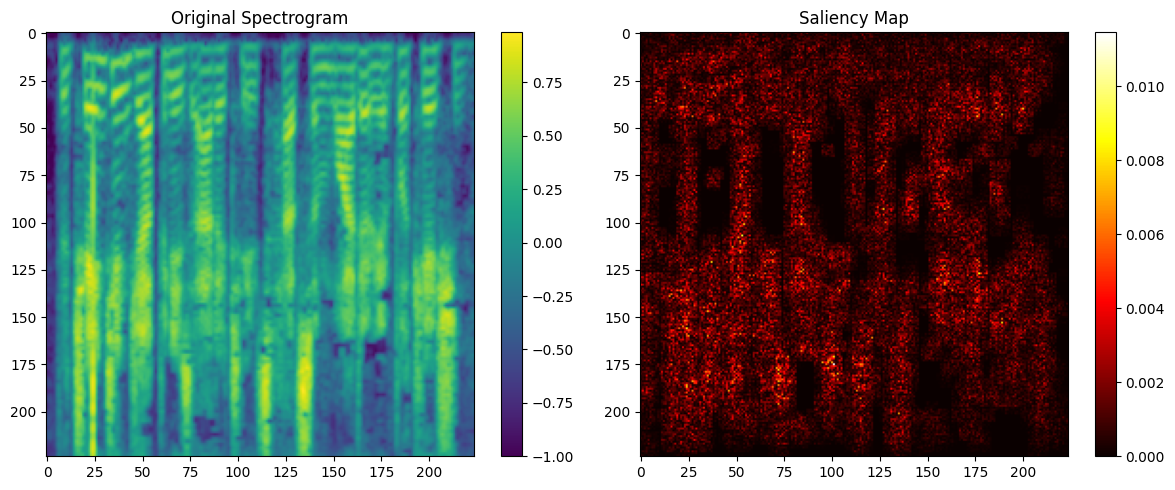

09:26:41 - INFO - Saliency map analysis completed


INFO:AIVoiceDetection:Saliency map analysis completed


09:26:41 - INFO - Using fixed occlusion window: (1, 14, 14)


INFO:AIVoiceDetection:Using fixed occlusion window: (1, 14, 14)


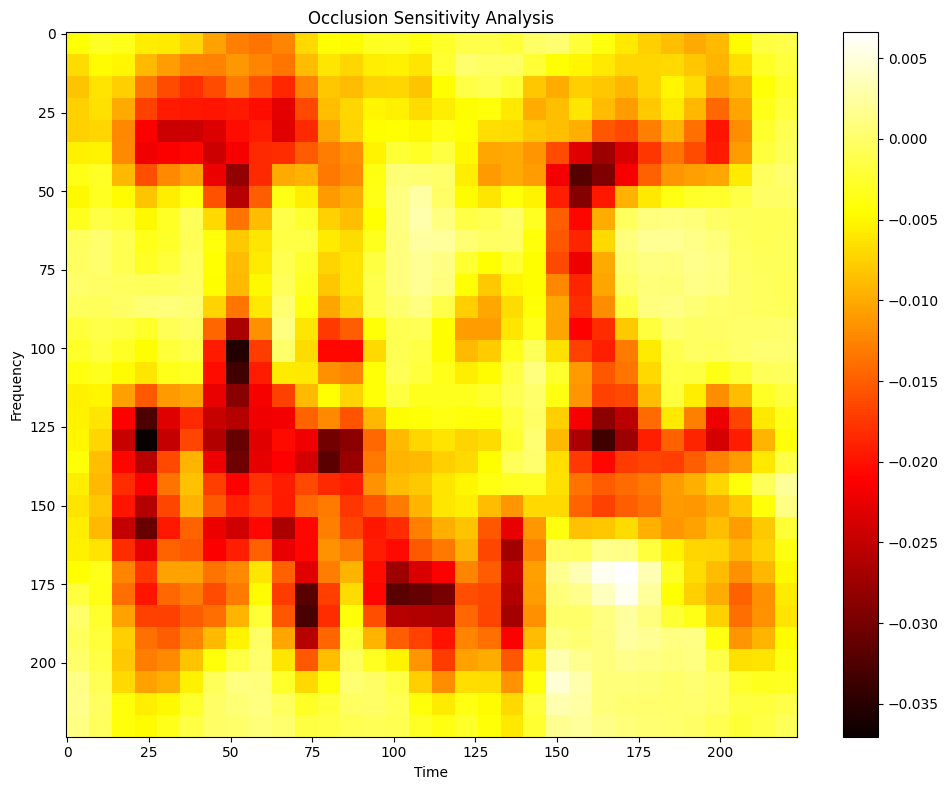

09:26:58 - INFO - Occlusion sensitivity analysis completed


INFO:AIVoiceDetection:Occlusion sensitivity analysis completed


5. Running SHAP Analysis...
09:26:58 - ERROR - SHAP analysis failed: 'XAIAnalyzer' object has no attribute 'dataset_builder'


ERROR:AIVoiceDetection:SHAP analysis failed: 'XAIAnalyzer' object has no attribute 'dataset_builder'


6. Running LIME Analysis...


  0%|          | 0/1000 [00:00<?, ?it/s]

09:26:59 - ERROR - LIME analysis failed: Given groups=1, weight of size [64, 1, 7, 7], expected input[10, 224, 224, 3] to have 1 channels, but got 224 channels instead


ERROR:AIVoiceDetection:LIME analysis failed: Given groups=1, weight of size [64, 1, 7, 7], expected input[10, 224, 224, 3] to have 1 channels, but got 224 channels instead


SHAP Analysis: ✗
LIME Analysis: ✗
09:26:59 - INFO - Comprehensive XAI report generated


INFO:AIVoiceDetection:Comprehensive XAI report generated


09:26:59 - INFO - Analyzing multiple samples for comprehensive XAI...


INFO:AIVoiceDetection:Analyzing multiple samples for comprehensive XAI...



Sample 1 - True label: AI


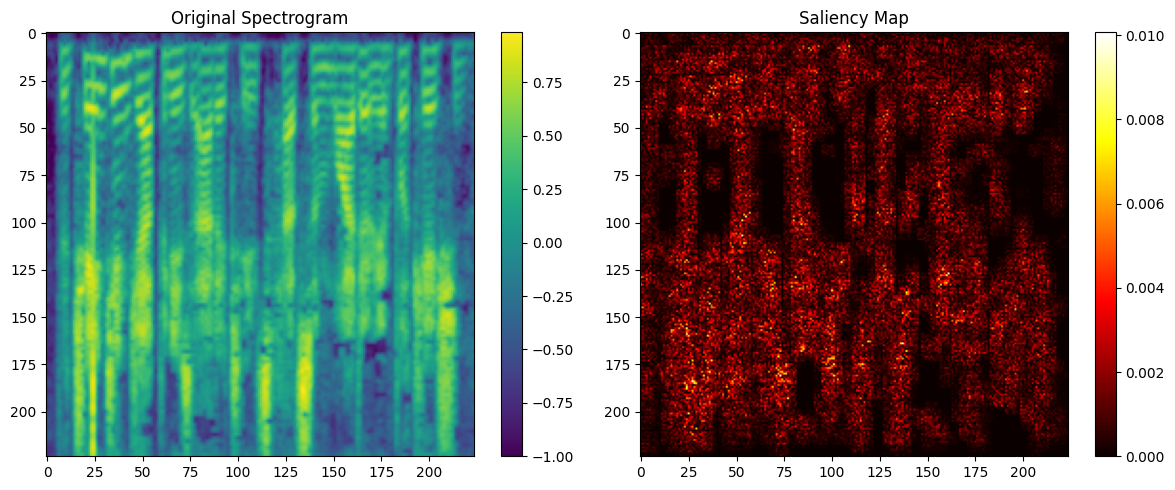

09:27:01 - INFO - Saliency map analysis completed


INFO:AIVoiceDetection:Saliency map analysis completed



Sample 2 - True label: Real


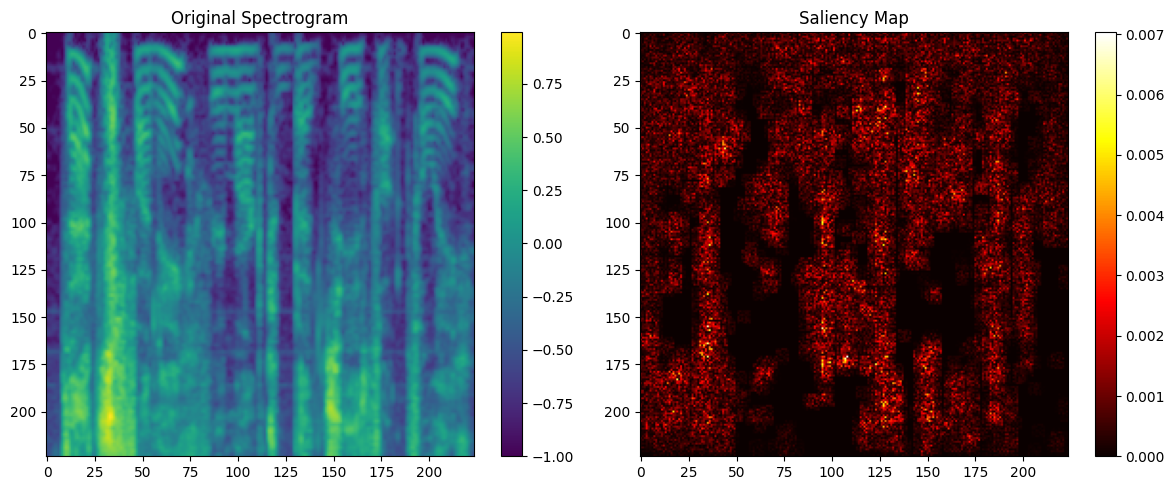

09:27:03 - INFO - Saliency map analysis completed


INFO:AIVoiceDetection:Saliency map analysis completed



Sample 3 - True label: AI


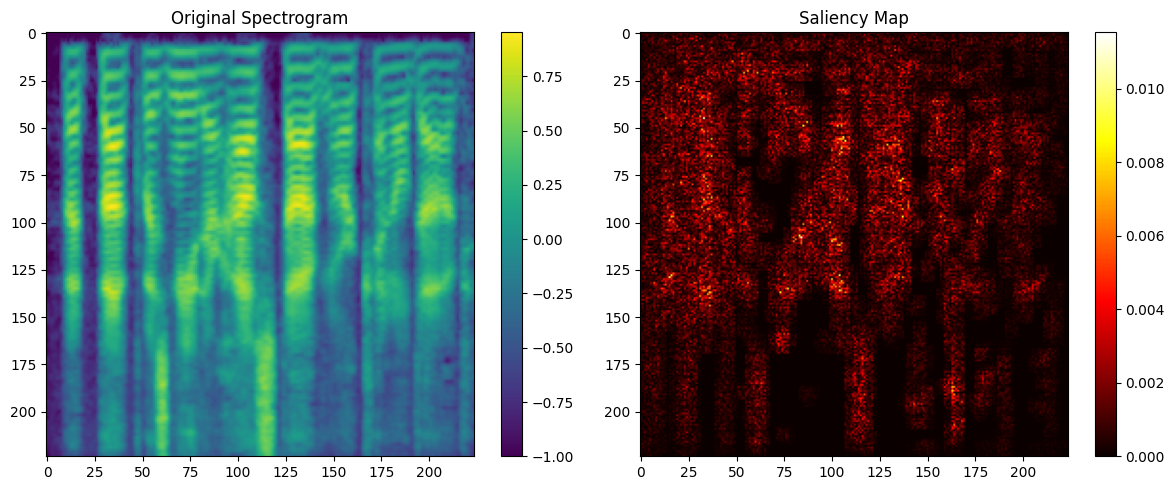

09:27:05 - INFO - Saliency map analysis completed


INFO:AIVoiceDetection:Saliency map analysis completed


09:27:05 - INFO - ================================================================================


INFO:AIVoiceDetection:================================================================================


09:27:05 - INFO - COMPREHENSIVE ANALYSIS COMPLETE


INFO:AIVoiceDetection:COMPREHENSIVE ANALYSIS COMPLETE


09:27:05 - INFO - ================================================================================


INFO:AIVoiceDetection:================================================================================



FINAL SUMMARY - ENHANCED ANALYSIS

INDIVIDUAL MODEL PERFORMANCE:
             Model  Accuracy  ROC-AUC  F1-Score
          resnet18    0.4658   0.5451    0.0488
   efficientnet_b0    0.4521   0.5000    0.0000
       densenet121    0.4521   0.8992    0.0000
mobilenet_v3_small    0.5479   0.5000    0.7080
     convnext_tiny    0.5479   0.8250    0.7080
           vit_b16    0.7260   0.8833    0.7917
         swin_tiny    0.7534   0.8409    0.7955

ENSEMBLE PERFORMANCE:
Accuracy: 0.5479
ROC-AUC: 0.8080
F1-Score: 0.7080

RECOMMENDATIONS:
Best Individual Model: densenet121 (AUC: 0.8992)
INDIVIDUAL model densenet121 recommended for deployment

XAI Analysis saved to: ./xai_results
Model comparisons saved to: ./xai_results
09:27:05 - INFO - Enhanced workflow completed successfully


INFO:AIVoiceDetection:Enhanced workflow completed successfully


09:27:05 - INFO - ================================================================================


INFO:AIVoiceDetection:================================================================================


09:27:05 - INFO - Program completed successfully


INFO:AIVoiceDetection:Program completed successfully


09:27:05 - INFO - ================================================================================


INFO:AIVoiceDetection:================================================================================


In [34]:
# ============================================================================
# RUN THE SYSTEM
# ============================================================================

if __name__ == "__main__":
    # Test GPU availability
    print("Using device:", Config.DEVICE)
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    else:
        print("Using CPU")

    # Run the main function
    main()

In [35]:
#!rm -rf ./dataset/ai && rm -rf ./dataset/real

In [36]:
!ls -l ./xai_results

total 5136
-rw-r--r-- 1 root root 236295 Nov 11 09:26 all_models_roc_curves.png
-rw-r--r-- 1 root root 192406 Nov 11 09:25 convnext_tiny_curves.png
-rw-r--r-- 1 root root 188696 Nov 11 09:25 densenet121_curves.png
-rw-r--r-- 1 root root 208778 Nov 11 09:25 efficientnet_b0_curves.png
-rw-r--r-- 1 root root  87352 Nov 11 09:26 ensemble_contributions.png
-rw-r--r-- 1 root root 186044 Nov 11 09:26 hybrid_ensemble_ensemble_curves.png
-rw-r--r-- 1 root root 552979 Nov 11 09:26 integrated_gradients_0.png
-rw-r--r-- 1 root root 614185 Nov 11 08:49 integrated_gradients_1.png
-rw-r--r-- 1 root root 210602 Nov 11 09:25 mobilenet_v3_small_curves.png
-rw-r--r-- 1 root root 512674 Nov 11 09:26 model_comparison_comprehensive.png
-rw-r--r-- 1 root root    884 Nov 11 09:26 model_comparison_detailed.csv
-rw-r--r-- 1 root root 734380 Nov 11 09:26 model_radar_chart.png
-rw-r--r-- 1 root root 126145 Nov 11 09:26 occlusion_sensitivity_0.png
-rw-r--r-- 1 root root 195060 Nov 11 09:25 resnet18_curves.png
-rw-

In [37]:
!zip -r xai_results.zip ./xai_results

  adding: xai_results/ (stored 0%)
  adding: xai_results/occlusion_sensitivity_0.png (deflated 33%)
  adding: xai_results/efficientnet_b0_curves.png (deflated 14%)
  adding: xai_results/model_radar_chart.png (deflated 6%)
  adding: xai_results/hybrid_ensemble_ensemble_curves.png (deflated 16%)
  adding: xai_results/integrated_gradients_0.png (deflated 8%)
  adding: xai_results/vit_b16_curves.png (deflated 16%)
  adding: xai_results/saliency_map_1.png (deflated 8%)
  adding: xai_results/all_models_roc_curves.png (deflated 13%)
  adding: xai_results/densenet121_curves.png (deflated 15%)
  adding: xai_results/mobilenet_v3_small_curves.png (deflated 14%)
  adding: xai_results/swin_tiny_curves.png (deflated 15%)
  adding: xai_results/saliency_map_0.png (deflated 8%)
  adding: xai_results/convnext_tiny_curves.png (deflated 16%)
  adding: xai_results/model_comparison_detailed.csv (deflated 50%)
  adding: xai_results/resnet18_curves.png (deflated 15%)
  adding: xai_results/ensemble_contributio